 **DOCUMENT SORTIES**

# Import de modules & données

#### Import des modules et fichiers

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

#### Ouverture des données

In [4]:
prises = 'Données/Lev3_CompoPrises.xlsx'
prises_nom_feuille = 'catchIds_2023-02-09'

df_prises = pd.read_excel(prises, sheet_name=prises_nom_feuille)

In [5]:
sorties = 'Données/Lev2-SortiesPeches.xlsx'
sorties_nom_feuille = 'SortiesPeches'

df_sorties = pd.read_excel(sorties, sheet_name=sorties_nom_feuille)

# Nettoyage des données

In [6]:
# Récupération des noms des colonnes
noms_colonnes_prises = df_prises.columns
noms_colonnes_sorties = df_sorties.columns

# Drop les duplicata (il n'y en a pas ici)
df_prises.drop_duplicates(inplace = True)

# On ordonne les prises suivant le trk_id, cela servira par la suite pour parcourir plus efficacement la liste
df_prises = df_prises.sort_values(by=["trk_id"])

### Modifications liées aux espèces et aux prises

In [7]:
# On drop les prises correspondant à des mauvaises espèces
mauvaises_especes = ['Clam', 'urchin', 'Cephalopod', 'Slipper lobster', 'Crab', 'Lobster', 'Unknown', 'None', 'Multiple']
df_prises = df_prises[~df_prises['taxaClean'].isin(mauvaises_especes)]
df_prises = df_prises.reset_index(drop=True)

# On corrige l'erreur "Tylosorus" par "Tylosurus"
df_prises['taxaClean'] = df_prises['taxaClean'].replace('Tylosorus', 'Tylosurus')

# On drop les sorties à 0 prises
df_combined = pd.merge(df_sorties, df_prises.groupby('trk_id').size().reset_index(name='NbdeCaptures'), on='trk_id', how='left')
df_sorties['NbdeCaptures'] = df_combined['NbdeCaptures'].fillna(0).astype(int)

df_sorties = df_sorties.drop(df_sorties[df_sorties['NbdeCaptures'] == 0].index)
df_sorties = df_sorties.reset_index(drop=True)

print(df_sorties)

       trk_id Inf_ID    newDate        hourStartNew          hourEndNew  \
0     AM001_1  AM001 2020-09-29 2020-09-29 16:54:00 2020-09-29 17:41:00   
1     AM001_3  AM001 2020-10-17 2020-10-17 12:16:00 2020-10-17 13:29:00   
2    AM001_37  AM001 2021-01-29 2021-01-29 10:00:00 2021-01-29 11:00:00   
3     AM001_4  AM001 2020-06-23 2020-06-23 09:18:00 2020-06-23 13:55:00   
4    AM001_40  AM001 2021-02-24 2021-02-24 09:00:00 2021-02-24 10:00:00   
..        ...    ...        ...                 ...                 ...   
883    SP_093  AM019 2019-05-25 2019-05-25 03:59:00 2019-05-25 12:54:00   
884    SP_144  AM019 2019-08-24 2019-08-24 03:24:00 2019-08-24 10:40:00   
885  AH010_14  AH010 2020-09-11 2020-09-11 20:00:00 2020-09-12 02:10:00   
886    SP_051  AM019 2019-03-22 2019-03-22 13:04:00 2019-03-22 16:17:00   
887    SP_168  AA003 2019-10-25 2019-10-25 06:19:00 2019-10-25 16:36:00   

     dayMinutes  nightMinutes  dayNightRatio    month              Gear  \
0          47.0         

### Modifications liées à la technique utilisée

In [8]:
# Construction d'une liste de sorties utilisables, i.e. on garde seulement celles où la technique de pêche est référencée

# positions_nan = [index for index, value in enumerate(df_sorties[noms_colonnes_sorties[9]]) if pd.isnull(value)]
# id_sorties_nan = [df_sorties[noms_colonnes_sorties[0]][k] for k in positions_nan]
# # print(id_sorties_nan)
# for k in range(len(positions_nan)):
#   df_prises = df_prises.drop(df_prises[df_prises['trk_id'] == id_sorties_nan[-k-1]].index)
#   df_sorties = df_sorties.drop(positions_nan[-k-1])     # le -k-1 est pour droper de bas en haut

# df_sorties = df_sorties.reset_index(drop=True)
# df_prises = df_prises.reset_index(drop=True)

# On rebaptise les "spear & inv" et "line & inv" en ‘spear’ et ‘line’
df_sorties['Gear'] = df_sorties['Gear'].replace('spear & inv', 'spear')
df_sorties['Gear'] = df_sorties['Gear'].replace('line & inv', 'line')

# On drop les sorties et les prises qui utilisent des couples de techniques ou des techniques hors de ['line', 'net', 'spear']
df_mauvaises_sorties = df_sorties[~df_sorties['Gear'].isin({'line', 'net', 'spear'})]

df_sorties = df_sorties[~df_sorties['trk_id'].isin(df_mauvaises_sorties['trk_id'])]
df_sorties = df_sorties.reset_index(drop=True)
df_prises = df_prises[~df_prises['trk_id'].isin(df_mauvaises_sorties['trk_id'])]
df_prises = df_prises.reset_index(drop=True)

# Différenciation de spear en jour et nuit
df_sorties.loc[(df_sorties['dayNightRatio'] >= 0.5) & (df_sorties['Gear']=="spear"), 'Gear'] = 'spear_day'
df_sorties.loc[(df_sorties['dayNightRatio'] < 0.5) & (df_sorties['Gear']=="spear"), 'Gear'] = 'spear_night'

# Il y a 2 sorties au spear pour lesquelles le 'dayNightRatio' n'est pas renseigné, on les drop
df_mauvaises_sorties_bis = df_sorties[df_sorties['Gear']=='spear']

df_sorties = df_sorties[~df_sorties['trk_id'].isin(df_mauvaises_sorties_bis['trk_id'])]
df_sorties = df_sorties.reset_index(drop=True)
df_prises = df_prises[~df_prises['trk_id'].isin(df_mauvaises_sorties_bis['trk_id'])]
df_prises = df_prises.reset_index(drop=True)

### Extraction de colonnes utiles

In [9]:
colonne_trk_id_prises = df_prises[noms_colonnes_prises[0]]    # Liste des trk_id pour toutes les prises
nb_capture = len(colonne_trk_id_prises)                       # à distinguer de nb_capture_total dans prises.ipynb
colonne_id_sortie = df_sorties[noms_colonnes_sorties[0]]              # Liste des trk_id des sorties
nb_sorties_total = len(colonne_id_sortie)
colonne_technique_peche_text = df_sorties[noms_colonnes_sorties[9]]   # Liste des techniques de pêche utilisées pour chaque sortie, 906 données

print(colonne_id_sortie)
print(df_sorties)

0       AA003_8
1       AH007_8
2      AH010_38
3      AM001_47
4      AM016_17
         ...   
831    TT002_81
832    TT002_96
833    TT002_97
834    TT003_21
835    TV003_31
Name: trk_id, Length: 836, dtype: object
       trk_id Inf_ID    newDate        hourStartNew          hourEndNew  \
0     AA003_8  AA003 2020-07-23 2020-07-23 09:41:00 2020-07-23 11:00:00   
1     AH007_8  AH008 2020-07-18 2020-07-18 10:38:00 2020-07-18 11:08:00   
2    AH010_38  AH010 2021-01-30 2021-01-30 05:30:00 2021-01-30 08:20:00   
3    AM001_47  AM001 2021-03-07 2021-03-07 16:00:00 2021-03-07 16:30:00   
4    AM016_17  AM016 2020-04-14 2020-04-14 15:00:00 2020-04-14 17:00:00   
..        ...    ...        ...                 ...                 ...   
831  TT002_81  TT002 2020-11-03 2020-11-03 18:54:00 2020-11-04 00:57:00   
832  TT002_96  TT002 2020-11-28 2020-11-28 20:00:00 2020-11-29 02:30:00   
833  TT002_97  TT002 2020-12-04 2020-12-04 20:31:00 2020-12-05 01:32:00   
834  TT003_21  TT003 2020-08-15 2

# Traitement des données

## Vectorisation des données

### Représentation vectorielle de la composition des prises

Fonction ***caract_espece***  permettant de vectoriser une espèce, et dictionnaire ***dict_capture_espece*** regroupant les vecteurs correspondant à chaque capture. On vectorise donc les captures.

In [10]:
colonne_id_capture = df_prises['fullID']    # id de captures (le fichier a été ordonné selon les trk_id (id de sortie))
colonne_especes_text = df_prises['taxaClean']
nb_capture_total = len(colonne_id_capture) # =48982

liste_especes = []
for i in colonne_especes_text :
  if i not in liste_especes and i!= 'Unknown' :
    liste_especes.append(i)
# 85 espèces différentes + 'Unknown'

# Création du vecteur qualifiant l'espèces capturée.
'''
pour chaque identifiant fullID on associe un vecteur caractérisant le caractère
de la prise composé de len(liste_especes) composantes toutes nulles
exceptée une valant 1 correspondant à l'espèce capturée
'''
def caract_espece (texte):
  nb_esp = len(liste_especes)
  espece = np.zeros(nb_esp)
  for i in range(nb_esp):
    if texte == liste_especes[i]:
      espece[i] = 1
      return espece
  return espece   # si aucune espèce n'est reconnue on renvoi le vecteur nul

dict_capture_espece = {}
for i in range(nb_capture_total) :
  dict_capture_espece[colonne_id_capture[i]] = caract_espece(colonne_especes_text[i])


In [11]:
# print(len(df_prises))
# print(len(colonne_id_sortie))
# print(len(liste_especes))
# print(df_prises)
# print(dict_capture_espece)

Nous allons représenter sous forme de vecteur les compositions des prises par sortie. Ainsi, à chaque sortie, nous allons associer un vecteur composé d'entiers naturels correspondant au nombre d'individus pêchés par espèce et par sortie.

In [12]:
# Pour rappel, caract_espece("nom d'espèce") renvoie un vecteur de taille len(liste_especes)
# avec des composantes toutes nulles sauf celle correspondant à l'indice de l'espèce qui vaut 1

def composition_prises_sortie(id_sortie):
  composition = np.zeros(len(liste_especes))

  for i in range(len(colonne_trk_id_prises)) :
    if colonne_trk_id_prises[i] == id_sortie :        # Si le trk_id de la prise correspond au trk_id : "id_sortie"
      composition = np.add(composition, caract_espece (colonne_especes_text[i]))
      if i<len(colonne_trk_id_prises)-1 and colonne_trk_id_prises[i+1] != id_sortie :   # On a ordonné les prises par trk_id pour gagner du temps ici
        return composition
  return composition

# Pour une composition avec les noms des espèces :
def composition_lettree_prises_sortie(id_sortie):
  composition = np.array([], dtype='str')

  for i in range(len(colonne_trk_id_prises)) :
    if colonne_trk_id_prises[i] == id_sortie :        # Si le trk_id de la prise correspond au trk_id : "id_sortie"
      composition = np.concatenate([composition, [colonne_especes_text[i]]])
      if i<len(colonne_trk_id_prises)-1 and colonne_trk_id_prises[i+1] != id_sortie :   # On a ordonné les prises par trk_id pour gagner du temps ici
        return composition
  return composition

print(composition_prises_sortie('AA003_16'))
print(np.sum(composition_prises_sortie('AA003_16')))
print(composition_lettree_prises_sortie('AA003_16'))
print(liste_especes)
print(nb_sorties_total)
print(len(colonne_id_sortie))

[11.  1.  4.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
19.0
['Parrotfish' 'Serranidae' 'Parupeneus sp.' 'Parrotfish' 'Parrotfish'
 'Sphyraena' 'Sphyraena' 'Parrotfish' 'Parupeneus sp.' 'Parrotfish'
 'Parrotfish' 'Parrotfish' 'Parrotfish' 'Parrotfish' 'Parrotfish' 'Platax'
 'Parupeneus sp.' 'Parupeneus sp.' 'Parrotfish']
['Parrotfish', 'Serranidae', 'Parupeneus sp.', 'Sphyraena', 'Platax', 'Caranx melampygus', 'Naso lituratus', 'Naso unicornis', 'Holocentrinae', 'Monotaxis', 'Mulloidichtys sp.', 'Myripristinae', 'Epinephelus sp.', 'Mullidae', 'Gnathodentex aureolineatus', 'Cheilinus sp.', 'Acanthurus sp.', 'Lutjanidae', 'Cephalopholis argus', 'Siganidae', 'Mugilidae', 'Chanos', 'Epibulus sp.', 'Kyphosus', 'Holocentridae', 'Polydactylus', 'L

In [13]:
liste_sorties_distinctes = colonne_id_sortie

On construit la matrice de la composition des pêches par sortie.

In [14]:
# On construit la matrice de capture
'''
Matrice avec en ligne les identifiants de sortie et en colonne les espèces capturées.
Ainsi pour lire la composition d'une sortie i , il faut lire la ligne i.
'''

matrice_capture = np.array( [composition_prises_sortie (id_sortie) for id_sortie in liste_sorties_distinctes])
# matrice de taille (906, 85)
# Un peu long car pour chaque sortie on reparcourt toutes les captures jusqu'à celles de la sortie désirée, pas optimal

In [15]:
print(liste_sorties_distinctes)
print(matrice_capture)
print(liste_especes)

0       AA003_8
1       AH007_8
2      AH010_38
3      AM001_47
4      AM016_17
         ...   
831    TT002_81
832    TT002_96
833    TT002_97
834    TT003_21
835    TV003_31
Name: trk_id, Length: 836, dtype: object
[[ 0.  0.  1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [13.  0.  5. ...  0.  0.  0.]
 [51.  0.  4. ...  0.  0.  0.]
 [18.  0. 12. ...  0.  0.  0.]]
['Parrotfish', 'Serranidae', 'Parupeneus sp.', 'Sphyraena', 'Platax', 'Caranx melampygus', 'Naso lituratus', 'Naso unicornis', 'Holocentrinae', 'Monotaxis', 'Mulloidichtys sp.', 'Myripristinae', 'Epinephelus sp.', 'Mullidae', 'Gnathodentex aureolineatus', 'Cheilinus sp.', 'Acanthurus sp.', 'Lutjanidae', 'Cephalopholis argus', 'Siganidae', 'Mugilidae', 'Chanos', 'Epibulus sp.', 'Kyphosus', 'Holocentridae', 'Polydactylus', 'Lutjanus monostigma', 'Acanthurus blochii', 'Naso sp.', 'Balistidae', 'Labridae', 'Lethrinus', 'Acanthurus olivaceus', 'Carangidae', 'Acanthuridae', 'Acanthurus xant

In [16]:
#matrice_capture_lettree = np.array( [composition_lettree_prises_sortie (id_sortie) for id_sortie in liste_sorties_distinctes])


### Représentation vectorielle de la technique de pêche

Il faut faire attention, il y a des valeurs qui ne sont pas rentrées et donc en valeur 'Nan' qui n'est pas une chaîne de caractères.

In [17]:
# Cette fonction permet de savoir combien il y a de techniques dans "texte"
def sectionnage (texte):
  L=[]
  number = 0
  for i in range(len(texte)):
    if texte[i] == '&':
      L.append(i)
      number += 1
  return ([number, L])

'''
la liste_technique correspond aux techniques utilisées dans l'ensemble de l'étude
'''
liste_techniques = []
l = 0
for i in colonne_technique_peche_text :
  l+= 1
  section = sectionnage(i)
  if section[0] == 0 and i not in liste_techniques :
      liste_techniques.append(i)
  else:
    liste_techniques_bis = []
    for k in range(section[0]):
      if k == 0 :
        liste_techniques_bis.append(i[0:section[1][k]])
      else:
        liste_techniques_bis.append(i[section[1][k-1]+1:section[1][k]])
      liste_techniques_bis.append(i[section[1][-1]+1:])

    for k in range(len(liste_techniques_bis)):
      if liste_techniques_bis[k][0] == ' ':
        liste_techniques_bis[k] = liste_techniques_bis[k][1:]
      if liste_techniques_bis[k][-1] == ' ':
        liste_techniques_bis[k] = liste_techniques_bis[k][:-1]
      if liste_techniques_bis[k] not in liste_techniques :
        liste_techniques.append(liste_techniques_bis[k])

print(liste_techniques)

'''
pour chaque identifiant id_sortie on associe un vecteur caractérisant le caractère
technique de pêche composé de composantes toutes nulles
exceptée certaines valant 1 correspondant aux techniques utilisées
'''
def vectorisation (texte):
  vecteur = [0 for i in range(len(liste_techniques))]
  for k in range(len(liste_techniques)) :
    if liste_techniques[k] in texte : #à améliorer, il pourrait y avoir des problèmes pour d'autres types d'engins
      vecteur[k] = 1
  return vecteur


['line', 'net', 'spear_day', 'spear_night']


Maintenant on construit la matrice des techniques utilisées par sorties, cette matrice a la liste des techniques utilisées par sortie en ligne.

In [18]:
# On construit la matrice des techniques
'''
matrice avec en ligne les identifiants de sortie et en colonne les techniques utilisées
Ainsi pour lire l'ensemble des techniques utilisées lors d'une sortie i , il faut lire la ligne i
'''

matrice_techniques = np.array( [vectorisation(colonne_technique_peche_text [i]) for i  in range(len(liste_sorties_distinctes))])

# matrice de taille (906, 7)
print(matrice_techniques.shape)

(836, 4)


## Création de df utiles

On transforme la matrice de capture en une dataframe utilisable

In [19]:
df_capture_trk = pd.DataFrame(matrice_capture, columns=liste_especes).rename_axis('trk_index', axis=0)
df_capture_trk.insert(0, 'trk_id', liste_sorties_distinctes)
df_capture = df_capture_trk.drop(columns=['trk_id'])

### df_capture_freq

In [20]:
capture_par_sortie = df_capture.sum(axis=1).to_frame(name='Total')
df_capture_freq = df_capture.div(capture_par_sortie['Total'], axis=0)

df_capture_freq = df_capture.div(capture_par_sortie['Total'], axis=0)

In [21]:
print(capture_par_sortie)

           Total
trk_index       
0            3.0
1            4.0
2            2.0
3            6.0
4            2.0
...          ...
831         12.0
832         11.0
833         46.0
834         78.0
835         49.0

[836 rows x 1 columns]


### Technique

In [22]:
df_capture_technique = pd.merge(df_sorties[["trk_id","Gear"]], df_capture_trk, on='trk_id', how='inner')
df_technique = df_capture_technique[["trk_id","Gear"]]

In [23]:
liste1 = df_capture_technique['trk_id']
liste2 = liste_sorties_distinctes

differences = [(elem1, elem2) for elem1, elem2 in zip(liste1, liste2) if elem1 != elem2]

print("Différences ordonnées:", differences)

Différences ordonnées: []


### Habitat

In [24]:
habitat = '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Lev3_Geographie/trackClassification_by_habitat.csv'

df_habitat_total = pd.read_csv(habitat, sep=';', decimal=',')
print(df_habitat_total)

valeurs_uniques = df_habitat_total['trk_id'].unique()
print(valeurs_uniques.shape)

        trk_id   habitat       length  relLength
0      AA003_1       out     0.000000   0.000000
1      AA003_1  BackReef     0.000000   0.000000
2      AA003_1  ForeReef  9616.171686   1.000000
3      AA003_1  Fringing     0.000000   0.000000
4      AA003_1   LagDeep     0.000000   0.000000
...        ...       ...          ...        ...
9919  TV003_98  BackReef  1614.395364   0.969686
9920  TV003_98  ForeReef     0.000000   0.000000
9921  TV003_98  Fringing     0.000000   0.000000
9922  TV003_98   LagDeep    50.468385   0.030314
9923  TV003_98      Pass     0.000000   0.000000

[9924 rows x 4 columns]
(1654,)


Sélection de l'habitat principal par sortie

In [25]:
idx_max_time = df_habitat_total.groupby('trk_id')['relLength'].idxmax()
idx_max = set(idx_max_time.values.astype(int)) & set(df_habitat_total.index)
# certaines sorties n'ont pas de données et donnent des indices impossibles dans idx_max_time

# print(idx_max_time)
print(len(idx_max))
print(df_habitat_total)

# Sélectionner uniquement les lignes correspondant à l'habitat avec le relLength maximum
df_habitat = df_habitat_total.loc[idx_max]

# Réinitialiser l'index si nécessaire
df_habitat.reset_index(drop=True, inplace=True)

# Afficher le résultat
# print(result_df[result_df['trk_id'] == 'TV003_98'])
print(df_habitat)

# Obtenir les représentants uniques et leur fréquence
valeurs_uniques = df_habitat['habitat'].value_counts()
liste_habitats = valeurs_uniques.reset_index()
liste_habitats.columns = ['Représentant', 'Fréquence']
print("Représentants uniques des habitats et leur fréquence :")
print(liste_habitats)

1649
        trk_id   habitat       length  relLength
0      AA003_1       out     0.000000   0.000000
1      AA003_1  BackReef     0.000000   0.000000
2      AA003_1  ForeReef  9616.171686   1.000000
3      AA003_1  Fringing     0.000000   0.000000
4      AA003_1   LagDeep     0.000000   0.000000
...        ...       ...          ...        ...
9919  TV003_98  BackReef  1614.395364   0.969686
9920  TV003_98  ForeReef     0.000000   0.000000
9921  TV003_98  Fringing     0.000000   0.000000
9922  TV003_98   LagDeep    50.468385   0.030314
9923  TV003_98      Pass     0.000000   0.000000

[9924 rows x 4 columns]
        trk_id   habitat        length  relLength
0     TM003_23  ForeReef  13865.599900   0.954892
1      AA003_1  ForeReef   9616.171686   1.000000
2     TM003_24  ForeReef   2078.389510   1.000000
3     AA003_10  BackReef   3998.686774   0.745440
4     AA003_11       out     11.031293   0.971579
...        ...       ...           ...        ...
1644  TM003_12  ForeReef   4335.

<ipython-input-25-a2b71ad43a9f>:2: RuntimeWarning: invalid value encountered in cast
  idx_max = set(idx_max_time.values.astype(int)) & set(df_habitat_total.index)
<ipython-input-25-a2b71ad43a9f>:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_habitat = df_habitat_total.loc[idx_max]


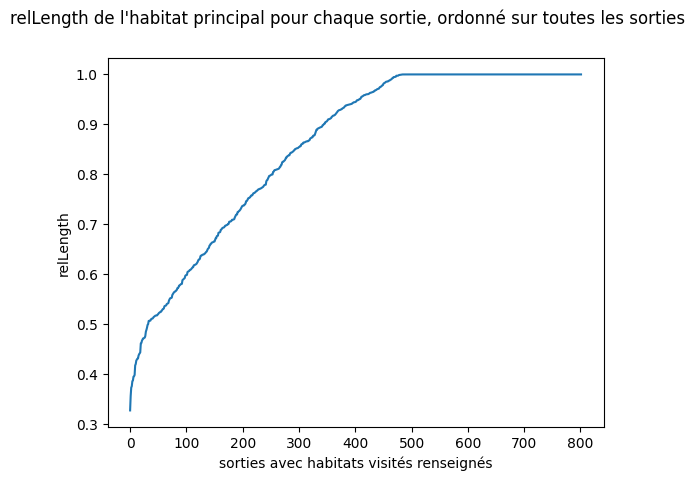

In [26]:
# relLength = df_habitat[df_habitat['trk_id'].isin(colonne_id_sortie)].query('1 >= relLength >= 0')['relLength'].sort_values()
relLength = df_habitat[df_habitat['trk_id'].isin(colonne_id_sortie)]['relLength'].sort_values()
plt.xlabel("sorties avec habitats visités renseignés")
plt.ylabel("relLength")
plt.suptitle("relLength de l'habitat principal pour chaque sortie, ordonné sur toutes les sorties")
plt.plot(np.arange(len(relLength)), relLength)

### Autres géoloc

#### Coast

In [27]:
coast = '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Lev3_Geographie/trackClassification_by_Coast.csv'

df_coast_total = pd.read_csv(coast, sep=';', decimal=',')
# print(df_coast_total)

valeurs_uniques = df_coast_total['trk_id'].unique()
# print(valeurs_uniques.shape)

idx_max_time = df_coast_total.groupby('trk_id')['relLength'].idxmax()
idx_max = set(idx_max_time.values.astype(int)) & set(df_coast_total.index)
# certaines sorties n'ont pas de données et donnent des indices impossibles dans idx_max_time

# print(idx_max_time)
# print(len(idx_max))
# print(df_coast_total)

# Sélectionner uniquement les lignes correspondant à la côte avec le relLength maximum
df_coast = df_coast_total.loc[idx_max]

# Réinitialiser l'index si nécessaire
df_coast.reset_index(drop=True, inplace=True)

# Afficher le résultat
# print(result_df[result_df['trk_id'] == 'TV003_98'])
# print(df_coast)

# Obtenir les représentants uniques et leur fréquence
valeurs_uniques = df_coast['Coast'].value_counts()
liste_coast = valeurs_uniques.reset_index()
liste_coast.columns = ['Représentant', 'Fréquence']
print("Représentants uniques des coasts et leur fréquence :")
print(liste_coast)

Représentants uniques des coasts et leur fréquence :
  Représentant  Fréquence
0         WEST        535
1        SOUTH        477
2         EAST        358
3        NORTH        248
4          out         31


<ipython-input-27-32e4821b386b>:10: RuntimeWarning: invalid value encountered in cast
  idx_max = set(idx_max_time.values.astype(int)) & set(df_coast_total.index)
<ipython-input-27-32e4821b386b>:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_coast = df_coast_total.loc[idx_max]


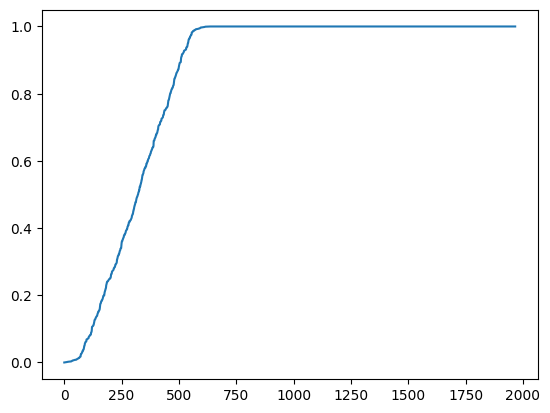

In [28]:
relLength = df_coast_total.query('1 >= relLength > 0')['relLength'].sort_values()

plt.plot(np.arange(len(relLength)), relLength)

#### Village

In [29]:
village = '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Lev3_Geographie/trackClassification_by_village.csv'

df_village_total = pd.read_csv(village, sep=';', decimal=',')
# print(df_village_total)

valeurs_uniques = df_village_total['trk_id'].unique()
# print(valeurs_uniques.shape)

idx_max_time = df_village_total.groupby('trk_id')['relLength'].idxmax()
idx_max = set(idx_max_time.values.astype(int)) & set(df_village_total.index)
# certaines sorties n'ont pas de données et donnent des indices impossibles dans idx_max_time

# print(idx_max_time)
# print(len(idx_max))
# print(df_village_total)

# Sélectionner uniquement les lignes correspondant au village avec le relLength maximum
df_village = df_village_total.loc[idx_max]

# Réinitialiser l'index si nécessaire
df_village.reset_index(drop=True, inplace=True)

# Afficher le résultat
# print(result_df[result_df['trk_id'] == 'TV003_98'])
# print(df_village)

# Obtenir les représentants uniques et leur fréquence
valeurs_uniques = df_village['village'].value_counts()
liste_village = valeurs_uniques.reset_index()
liste_village.columns = ['Représentant', 'Fréquence']
print("Représentants uniques des villages et leur fréquence :")
print(liste_village)

Représentants uniques des villages et leur fréquence :
   Représentant  Fréquence
0        maatea        356
1        varari        238
2       vaianae        194
3         atiha        120
4         haumi        111
5      maharepa         85
6       tiahura         72
7         patae         68
8       haapiti         62
9     afareaitu         57
10      teavaro         55
11        tiaia         52
12     papetoai         41
13       paopao         40
14       vaiare         33
15        temae         33
16          out         32


<ipython-input-29-77647bdec6d8>:10: RuntimeWarning: invalid value encountered in cast
  idx_max = set(idx_max_time.values.astype(int)) & set(df_village_total.index)
<ipython-input-29-77647bdec6d8>:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_village = df_village_total.loc[idx_max]


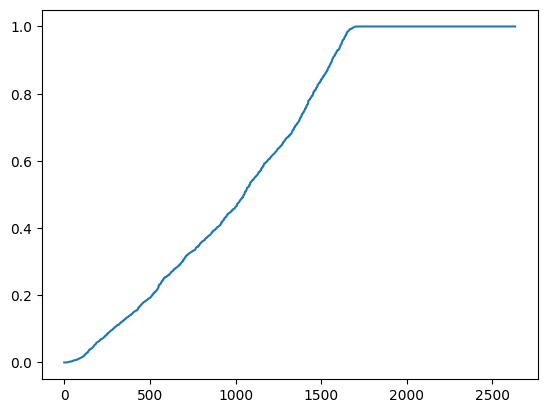

In [30]:
relLenght = df_village_total.query('1 >= relLength > 0')['relLength'].sort_values()

plt.plot(np.arange(len(relLenght)), relLenght)

#### passToPass

In [31]:
passToPass = '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Lev3_Geographie/trackClassification_by_passToPass.csv'

df_passToPass_total = pd.read_csv(passToPass, sep=';', decimal=',')
# print(df_passToPass_total)

valeurs_uniques = df_passToPass_total['trk_id'].unique()
# print(valeurs_uniques.shape)

idx_max_time = df_passToPass_total.groupby('trk_id')['relLength'].idxmax()
idx_max = set(idx_max_time.values.astype(int)) & set(df_passToPass_total.index)
# certaines sorties n'ont pas de données et donnent des indices impossibles dans idx_max_time

# print(idx_max_time)
# print(len(idx_max))
# print(df_passToPass_total)

# Sélectionner uniquement les lignes correspondant au village avec le relLength maximum
df_passToPass = df_passToPass_total.loc[idx_max]

# Réinitialiser l'index si nécessaire
df_passToPass.reset_index(drop=True, inplace=True)

# Afficher le résultat
# print(result_df[result_df['trk_id'] == 'TV003_98'])
# print(df_passToPass)

# Obtenir les représentants uniques et leur fréquence
valeurs_uniques = df_passToPass['passToPass'].value_counts()
liste_passToPass = valeurs_uniques.reset_index()
liste_passToPass.columns = ['Représentant', 'Fréquence']
print("Représentants uniques des passToPass et leur fréquence :")
print(liste_passToPass)

Représentants uniques des passToPass et leur fréquence :
   Représentant  Fréquence
0        Maatea        478
1       Vaianae        265
2        Varari        253
3         Patae        137
4         Haumi         90
5         Tiaia         86
6       Tiahura         72
7       Teavaro         69
8       Pihaena         60
9      Maharepa         54
10          out         32
11     Papetoai         27
12        Temae         26


<ipython-input-31-98136493be47>:10: RuntimeWarning: invalid value encountered in cast
  idx_max = set(idx_max_time.values.astype(int)) & set(df_passToPass_total.index)
<ipython-input-31-98136493be47>:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_passToPass = df_passToPass_total.loc[idx_max]


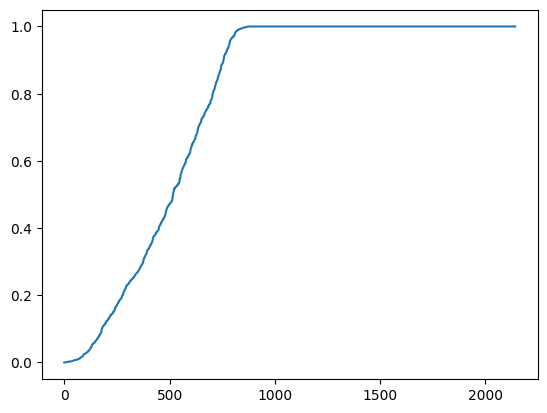

In [32]:
relLenght = df_passToPass_total.query('1 >= relLength > 0')['relLength'].sort_values()

plt.plot(np.arange(len(relLenght)), relLenght)

### Ajout de trk_id

In [33]:
df_habitat_order = pd.merge(liste_sorties_distinctes, df_habitat, on='trk_id', how='left')
df_habitat_order = df_habitat_order[["trk_id","habitat"]]
df_capture_habitat = pd.merge(df_habitat_order, df_capture_trk, on='trk_id', how='outer')
# df_capture_habitat = df_capture_habitat.dropna(subset = ['habitat'])

df_coast_order = pd.merge(liste_sorties_distinctes, df_coast, on='trk_id', how='left')
df_coast_order = df_coast_order[["trk_id","Coast"]]
df_capture_coast = pd.merge(df_coast_order, df_capture_trk, on='trk_id', how='outer')

df_village_order = pd.merge(liste_sorties_distinctes, df_village, on='trk_id', how='left')
df_village_order = df_village_order[["trk_id","village"]]
df_capture_village = pd.merge(df_village_order, df_capture_trk, on='trk_id', how='outer')

df_passToPass_order = pd.merge(liste_sorties_distinctes, df_passToPass, on='trk_id', how='left')
df_passToPass_order = df_passToPass_order[["trk_id","passToPass"]]
df_capture_passToPass = pd.merge(df_passToPass_order, df_capture_trk, on='trk_id', how='outer')

df_capture_geoloc = pd.merge(df_capture_habitat, df_capture_coast)
df_capture_geoloc = pd.merge(df_capture_geoloc, df_capture_village)
df_capture_geoloc = pd.merge(df_capture_geoloc, df_capture_passToPass)

colonne_a_deplacer = df_capture_geoloc.pop('Coast')
df_capture_geoloc.insert(2, 'Coast', colonne_a_deplacer)
colonne_a_deplacer = df_capture_geoloc.pop('village')
df_capture_geoloc.insert(2, 'village', colonne_a_deplacer)
colonne_a_deplacer = df_capture_geoloc.pop('passToPass')
df_capture_geoloc.insert(2, 'passToPass', colonne_a_deplacer)

# print(df_capture_geoloc)

In [34]:
liste1 = df_capture_habitat['trk_id']
liste2 = liste_sorties_distinctes

differences = [(elem1, elem2) for elem1, elem2 in zip(liste1, liste2) if elem1 != elem2]

print("Différences ordonnées:", differences)

Différences ordonnées: []


### Création de df_capture_total

In [35]:
df_capture_total = pd.merge(df_capture_technique, df_capture_geoloc)

colonne_a_deplacer = df_capture_total.pop('habitat')
df_capture_total.insert(2, 'habitat', colonne_a_deplacer)
colonne_a_deplacer = df_capture_total.pop('Coast')
df_capture_total.insert(2, 'Coast', colonne_a_deplacer)
colonne_a_deplacer = df_capture_total.pop('village')
df_capture_total.insert(2, 'village', colonne_a_deplacer)
colonne_a_deplacer = df_capture_total.pop('passToPass')
df_capture_total.insert(2, 'passToPass', colonne_a_deplacer)

# print(df_capture_total)

In [36]:
df_capture_total.insert(2, 'nb_captures', capture_par_sortie['Total'])
especes_par_sortie = df_capture.apply(lambda row: np.count_nonzero(row), axis=1).to_frame(name='Total')

df_capture_total.insert(3, 'nb_especes', especes_par_sortie['Total'])

In [37]:
print(df_capture_total.columns)

Index(['trk_id', 'Gear', 'nb_captures', 'nb_especes', 'passToPass', 'village',
       'Coast', 'habitat', 'Parrotfish', 'Serranidae', 'Parupeneus sp.',
       'Sphyraena', 'Platax', 'Caranx melampygus', 'Naso lituratus',
       'Naso unicornis', 'Holocentrinae', 'Monotaxis', 'Mulloidichtys sp.',
       'Myripristinae', 'Epinephelus sp.', 'Mullidae',
       'Gnathodentex aureolineatus', 'Cheilinus sp.', 'Acanthurus sp.',
       'Lutjanidae', 'Cephalopholis argus', 'Siganidae', 'Mugilidae', 'Chanos',
       'Epibulus sp.', 'Kyphosus', 'Holocentridae', 'Polydactylus',
       'Lutjanus monostigma', 'Acanthurus blochii', 'Naso sp.', 'Balistidae',
       'Labridae', 'Lethrinus', 'Acanthurus olivaceus', 'Carangidae',
       'Acanthuridae', 'Acanthurus xanthopterus', 'Cephalopholis sp.',
       'Priacanthidae', 'Lutjanus gibbus', 'Kuhliidae',
       'Crenimugil crenilabis', 'Tylosurus', 'Albula sp.', 'Lutjanus bohar',
       'Aphareus sp.', 'Lethrinidae', 'Liza vaigiensis',
       'Acanthurus 

In [38]:
df_capture_freq = df_capture_total[liste_especes].div(capture_par_sortie['Total'], axis=0)
df_capture_freq = pd.merge(df_capture_total[['trk_id', 'Gear', 'nb_captures', 'nb_especes', 'passToPass', 'village', 'Coast', 'habitat']], df_capture_freq, left_index=True, right_index=True)
# print(capture_par_sortie)
# # print(df_capture_total[liste_especes])
# print(df_capture_technique)
# print(df_capture_habitat)
# print(df_capture_freq)

# liste1 = df_capture_technique['trk_id']
# liste2 = df_capture_habitat['trk_id']

# differences = [(elem1, elem2) for elem1, elem2 in zip(liste1, liste2) if elem1 != elem2]

# print("Différences ordonnées:", differences)

Création d'un df avec seulement des valeurs numériques (pas de texte)

# Visualisations et clustermaps

In [39]:
import plotly.express as px
import seaborn as sns

## Global

###avec données brutes

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 300x200 with 0 Axes>

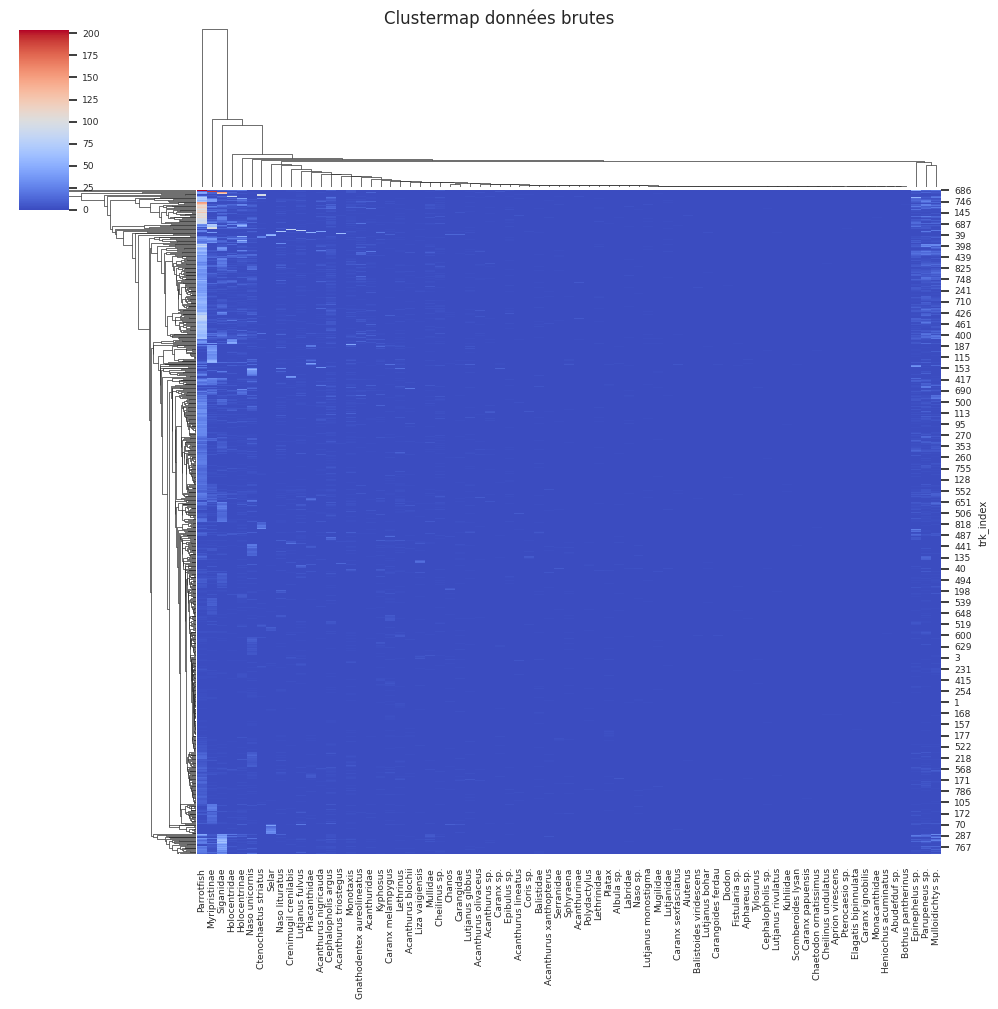

In [40]:
plt.figure(figsize=(3, 2))
sns.set(font_scale=0.6)
# sns.heatmap(df_capture.astype(float), annot=True, cmap='coolwarm', linewidths=.5)
sns.clustermap(df_capture.astype(float), cmap='coolwarm', xticklabels = True)
plt.suptitle('Clustermap données brutes',fontsize=12, x=0.5, y=1)
plt.show()

###avec données normalisées moyenne à 0 et variance à 1 pour chaque espèce

In [41]:
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x300 with 0 Axes>

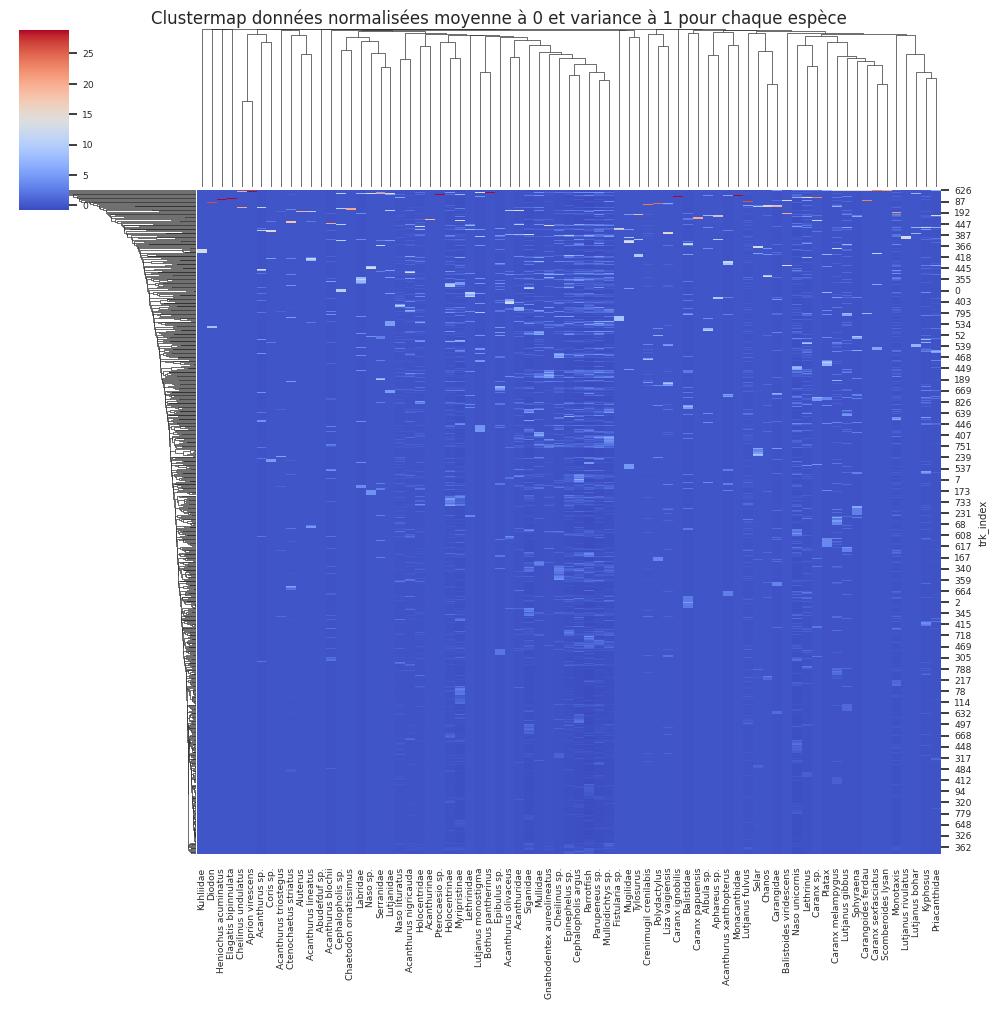

In [42]:
scaler = StandardScaler()
matrice_capture_standardisee = scaler.fit_transform(matrice_capture)

df_capture_norm = pd.DataFrame(matrice_capture_standardisee, columns=liste_especes).rename_axis('trk_index', axis=0)
# print(df_capture)

plt.figure(figsize=(10, 3))
sns.set(font_scale=0.6)
# sns.heatmap(df_capture.astype(float), annot=True, cmap='coolwarm', linewidths=.5)
cluster_m0_v1 = sns.clustermap(df_capture_norm.astype(float), cmap='coolwarm', xticklabels = True)
plt.suptitle('Clustermap données normalisées moyenne à 0 et variance à 1 pour chaque espèce',fontsize=12, x=0.5, y=1)
plt.show()

'''On récupère les données réarrangées de la cluster map'''

# Récupération des données à partir de l'objet ClusterGrid
donnees_m0_v1 = cluster_m0_v1.data2d

####observations

- les sorties avec une espèce particulièrement pêchée sont toutes en haut
- on peut voir une corrélation entre plusieurs espèces vers la droite (elles sont régulièrement pêchées ensemble)


(836, 2)


/usr/local/lib/python3.10/dist-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<ipython-input-43-04232e6be6f0>:23: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
<ipython-input-43-04232e6be6f0>:23: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)


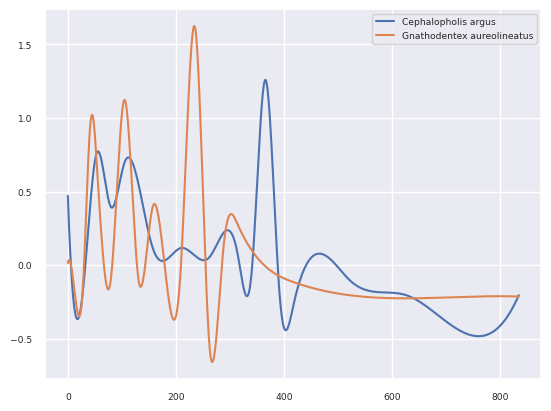

In [43]:
from scipy import interpolate
# df_nouveau = donnees_m0_v1[['Siganidae', 'Mullidae','Gnathodentex aureolineatus','Cheilinus sp.', 'Epinephelus sp.', 'Cephalopholis argus', 'Parrotfish', 'Parupeneus sp.', 'Mulloidichtys sp.']]
df_nouveau = donnees_m0_v1[['Cephalopholis argus', 'Gnathodentex aureolineatus']]

print(df_nouveau.values.shape)

moyenne = []
ecart_type = []
for i in range(len(df_nouveau.values[:,1])):
  moyenne.append(np.mean([df_nouveau.values[i,j] for j in range(len(df_nouveau.values[1,:]))]))
  ecart_type.append(np.var([df_nouveau.values[i,j] for j in range(len(df_nouveau.values[1,:]))]))
# Y=[]
for i in range(len(df_nouveau.values[1,:])):

  x = range(len(df_nouveau))
  y = df_nouveau.values[:, i]
  # Y.append(y)
  #min_value_y = np.min(y)
  #y = [None if valeur <= min_value_y+1 else valeur for valeur in y]

  # Ajustez un polynôme de degré 2 (vous pouvez ajuster le degré selon vos besoins)
  degree = 60
  coefficients = np.polyfit(x, y, degree)

  # Générez des valeurs interpolées
  x_interpolated = np.linspace(min(x), max(x), 100)
  y_interpolated = np.polyval(coefficients, x_interpolated)
  spline = interpolate.UnivariateSpline(x, y , s=700, k = 3)
  # spline.set_smoothing_factor(5)
  y_inter_bis = spline(x)


  # Tracez le nuage de points original
  #plt.scatter(x, y, alpha=0.5, label='Données originales')
#plt.scatter(Y[0], Y[1], alpha=0.5, label='Données originales')

  # Tracez l'interpolation polynomiale
  #plt.plot(x_interpolated, y_interpolated, label=f'{df_nouveau.columns[i]}')
  plt.plot(x, y_inter_bis, label=f'{df_nouveau.columns[i]}')

  #plt.scatter(range(len(df_nouveau.values[:,1])),moyenne, alpha = 1, c= 'red')
  #plt.scatter(range(len(df_nouveau.values[:,1])),ecart_type, alpha = 1, c= 'blue')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


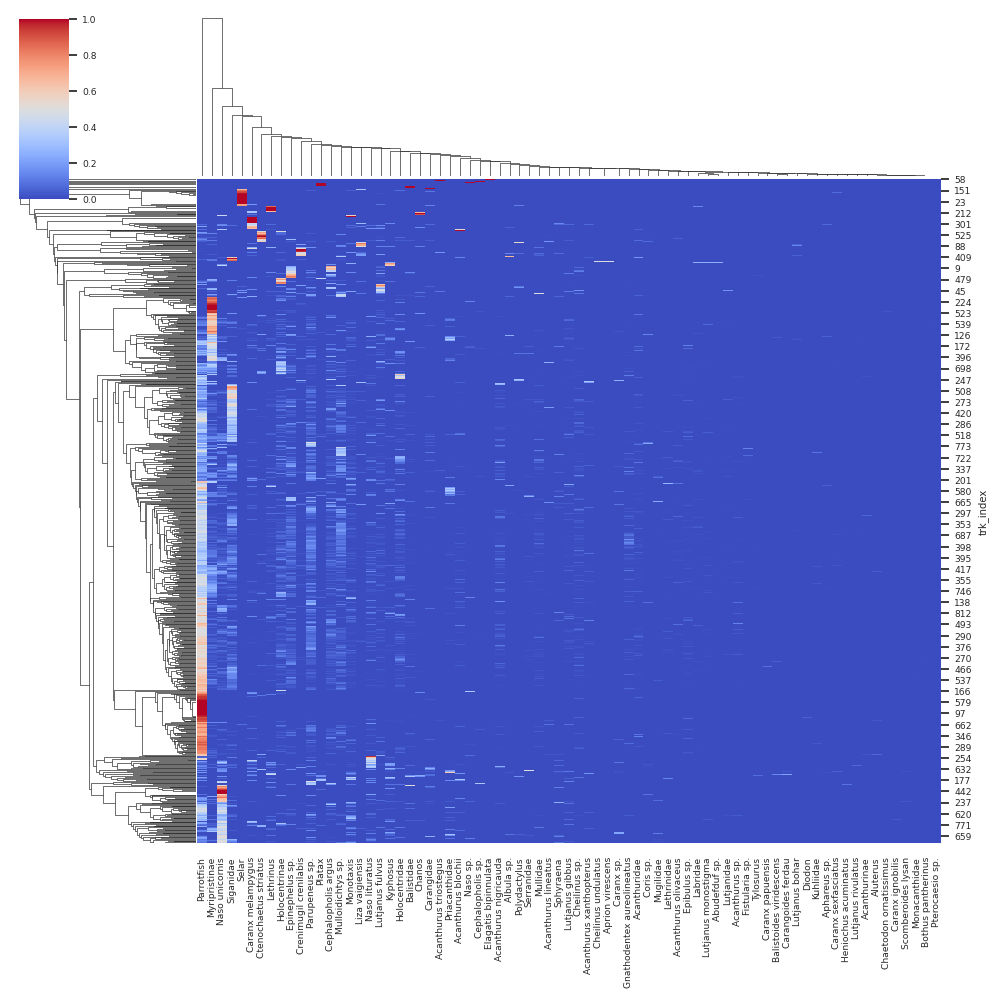

In [44]:
capture_par_sortie = df_capture.sum(axis=1).to_frame(name='Total')
df_capture_freq = df_capture.div(capture_par_sortie['Total'], axis=0)
cluster_freq = sns.clustermap(df_capture_freq.astype(float), cmap='coolwarm', xticklabels = True);
donnees_freq = cluster_freq.data2d

df_nouveau = donnees_freq[['Siganidae', 'Mullidae','Gnathodentex aureolineatus','Cheilinus sp.', 'Epinephelus sp.', 'Cephalopholis argus', 'Parrotfish', 'Parupeneus sp.', 'Mulloidichtys sp.']]

/usr/local/lib/python3.10/dist-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<ipython-input-45-008d9fa9de04>:17: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
<ipython-input-45-008d9fa9de04>:17: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
<ipython-input-45-008d9fa9de04>:17: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
<ipython-input-45-008d9fa9de04>:17: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
<ipython-input-45-008d9fa9de04>:17: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
<ipython-input-45-008d9fa9de04>:17: Ra

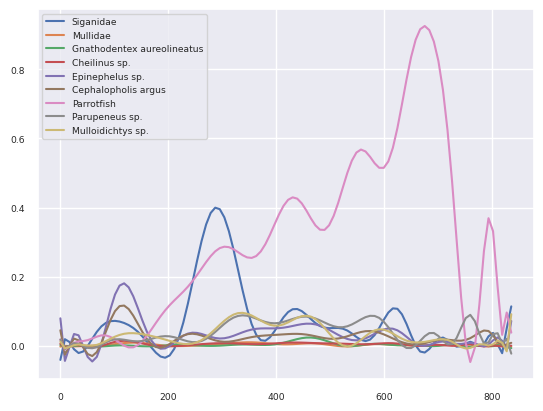

In [45]:
moyenne = []
ecart_type = []
for i in range(len(df_nouveau.values[:,1])):
  moyenne.append(np.mean([df_nouveau.values[i,j] for j in range(len(df_nouveau.values[1,:]))]))
  ecart_type.append(np.var([df_nouveau.values[i,j] for j in range(len(df_nouveau.values[1,:]))]))

for i in range(len(df_nouveau.values[1,:])):

  x = range(len(df_nouveau))
  y = df_nouveau.values[:, i]

  #min_value_y = np.min(y)
  #y = [None if valeur <= min_value_y+1 else valeur for valeur in y]

  # Ajustez un polynôme de degré 2 (vous pouvez ajuster le degré selon vos besoins)
  degree = 60
  coefficients = np.polyfit(x, y, degree)

  # Générez des valeurs interpolées
  x_interpolated = np.linspace(min(x), max(x), 100)
  y_interpolated = np.polyval(coefficients, x_interpolated)

  # Tracez le nuage de points original
  #plt.scatter(x, y, alpha=0.5, label='Données originales')

  # Tracez l'interpolation polynomiale
  plt.plot(x_interpolated, y_interpolated, label=f'{df_nouveau.columns[i]}')

  #plt.scatter(range(len(df_nouveau.values[:,1])),moyenne, alpha = 1, c= 'red')
  #plt.scatter(range(len(df_nouveau.values[:,1])),ecart_type, alpha = 1, c= 'blue')
plt.legend()
plt.show()

###avec données en fréquence

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 800x600 with 0 Axes>

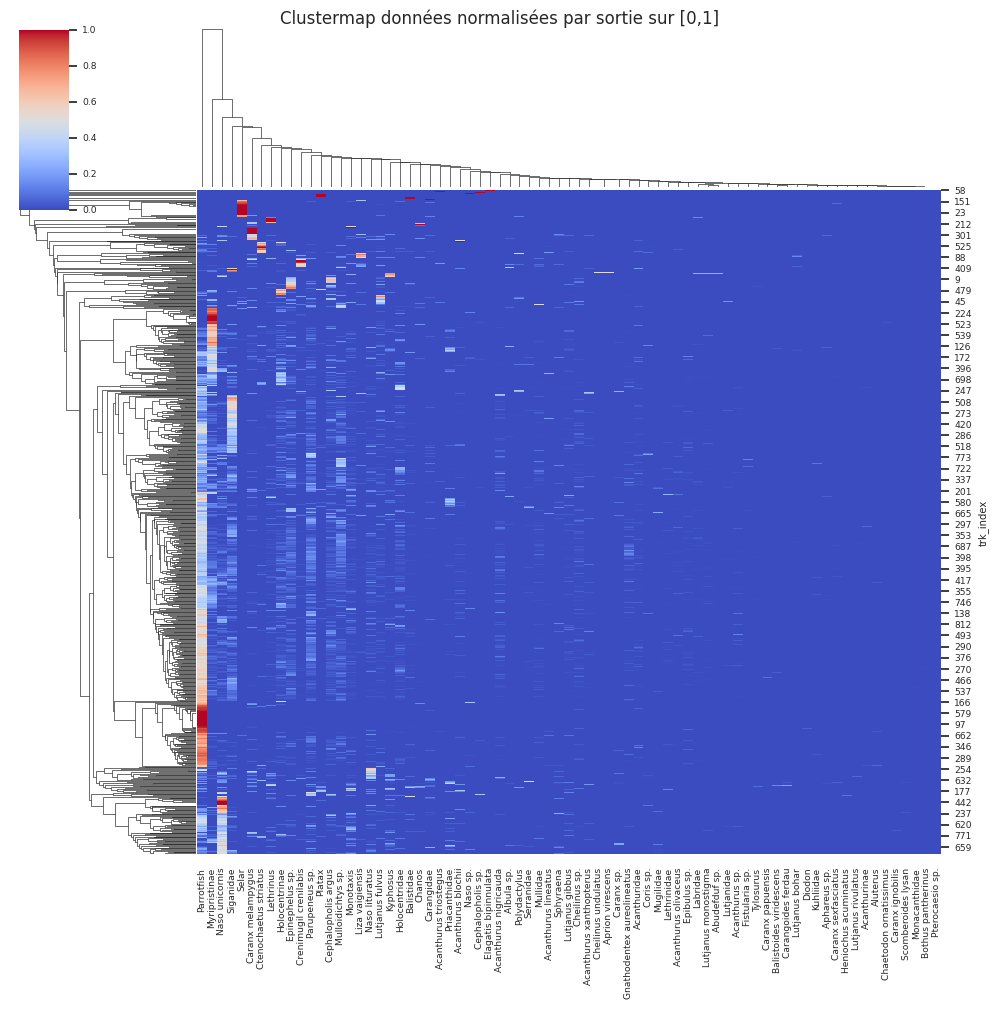

In [46]:
# capture_par_sortie = df_capture.sum(axis=1).to_frame(name='Total')
# df_capture_freq = df_capture.div(capture_par_sortie['Total'], axis=0)
plt.figure(figsize=(8, 6))
cluster_freq = sns.clustermap(df_capture_freq.astype(float), cmap='coolwarm', xticklabels = True)
plt.suptitle('Clustermap données normalisées par sortie sur [0,1]',fontsize=12, x=0.5, y=1)
plt.show()

donnees_freq = cluster_freq.data2d.values
index_labels = cluster_freq.dendrogram_row.reordered_ind
column_labels = cluster_freq.dendrogram_col.reordered_ind

donnees_freq = pd.DataFrame(donnees_freq, index=df_capture_freq.index[index_labels], columns=df_capture_freq.columns[column_labels])

####Observations

- quand on pêche un grand nombre d'une espèce, la sortie paraît presque systématiquement ciblée sur cette espèce (quand y une espèce en rouge, les autres espèces capturées lors de la sortie sont en bleu)
- Il semblerait y avoir une relation intéressante de dépendance entre la 2ieme et la 3ieme espèce (Myripristinae et Naso unicornis)
- peut être aussi entre la 1ere et la 4ieme (parrot fish et Siganidae)

/usr/local/lib/python3.10/dist-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
<ipython-input-47-496fdd33540f>:19: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
<ipython-input-47-496fdd33540f>:19: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
<ipython-input-47-496fdd33540f>:19: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
<ipython-input-47-496fdd33540f>:19: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)


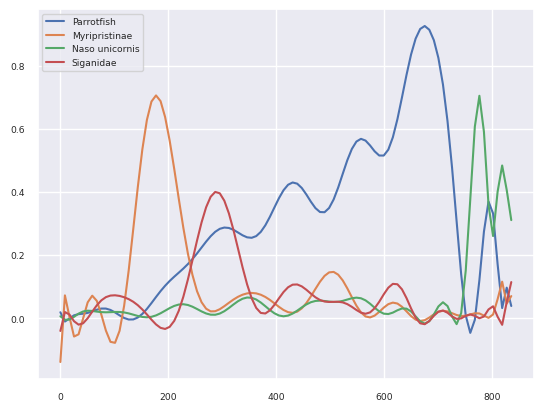

In [47]:
df_nouveau = donnees_freq[['Parrotfish', 'Myripristinae','Naso unicornis','Siganidae']]

moyenne = []
ecart_type = []
for i in range(len(df_nouveau.values[:,1])):
  moyenne.append(np.mean([df_nouveau.values[i,j] for j in range(len(df_nouveau.values[1,:]))]))
  ecart_type.append(np.var([df_nouveau.values[i,j] for j in range(len(df_nouveau.values[1,:]))]))

for i in range(len(df_nouveau.values[1,:])):

  x = range(len(df_nouveau))
  y = df_nouveau.values[:, i]

  #min_value_y = np.min(y)
  #y = [None if valeur <= min_value_y+1 else valeur for valeur in y]

  # Ajustez un polynôme de degré 2 (vous pouvez ajuster le degré selon vos besoins)
  degree = 60
  coefficients = np.polyfit(x, y, degree)

  # Générez des valeurs interpolées
  x_interpolated = np.linspace(min(x), max(x), 100)
  y_interpolated = np.polyval(coefficients, x_interpolated)

  # Tracez le nuage de points original
  #plt.scatter(x, y, alpha=0.5, label='Données originales')

  # Tracez l'interpolation polynomiale
  plt.plot(x_interpolated, y_interpolated, label=f'{df_nouveau.columns[i]}')

  #plt.scatter(range(len(df_nouveau.values[:,1])),moyenne, alpha = 1, c= 'red')
  #plt.scatter(range(len(df_nouveau.values[:,1])),ecart_type, alpha = 1, c= 'blue')
plt.legend()
plt.show()

## Sélection d'espèces les plus pêchées

In [48]:
capture_par_espece = df_capture.sum().to_frame(name='Total')
capture_par_espece_order = capture_par_espece.sort_values(by='Total')
capture_par_espece_order = capture_par_espece_order.rename_axis('taxaClean', axis=0)
nb_captures = capture_par_espece.sum()
# print(df_capture)
# print(capture_par_espece.index)
# print(capture_par_espece_order.index)

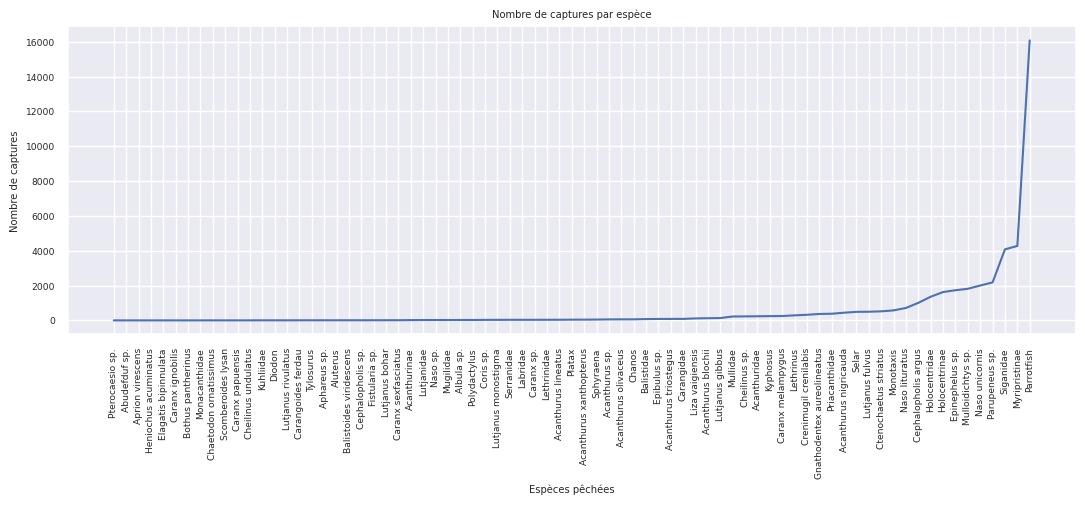

In [49]:
plt.figure(figsize=(13, 4))
plt.plot(capture_par_espece_order)
plt.xlabel("Espèces pêchées")
plt.ylabel("Nombre de captures")
plt.title("Nombre de captures par espèce")
plt.xticks(rotation='vertical')
plt.show()

In [50]:
print(capture_par_espece_order.columns)
capture_par_espece_order_filtered = capture_par_espece_order.query('Total >= 1000')
print(capture_par_espece_order_filtered.size)
print(capture_par_espece_order_filtered.index)
df_capture_espece_filtre = df_capture.loc[:, df_capture.columns.intersection(capture_par_espece_order_filtered.index)]
# print(df_capture_filtre)

Index(['Total'], dtype='object')
10
Index(['Cephalopholis argus', 'Holocentridae', 'Holocentrinae',
       'Epinephelus sp.', 'Mulloidichtys sp.', 'Naso unicornis',
       'Parupeneus sp.', 'Siganidae', 'Myripristinae', 'Parrotfish'],
      dtype='object', name='taxaClean')


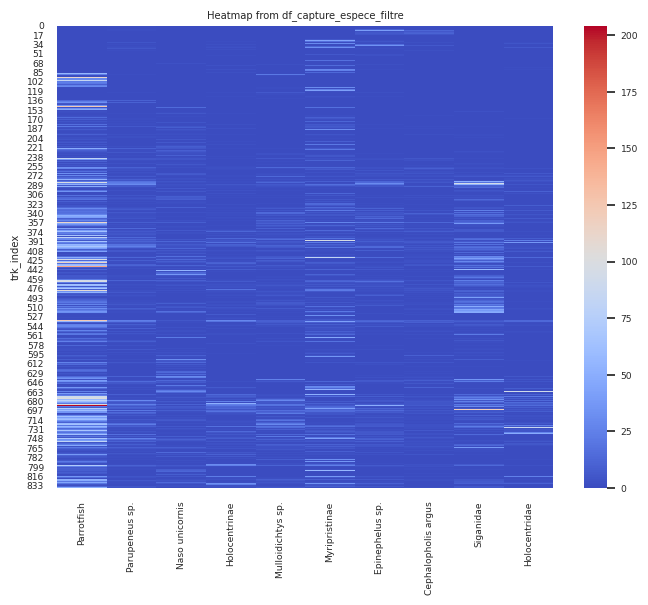

In [51]:
plt.figure(figsize=(8, 6))
# sns.heatmap(df_capture_filtre.astype(float), annot=True, cmap='coolwarm', linewidths=.5)
sns.heatmap(df_capture_espece_filtre.astype(float), cmap='coolwarm')
plt.title('Heatmap from df_capture_espece_filtre')
plt.show()

## Sélection des sorties

### Par nombre de captures

In [52]:
capture_par_sortie = df_capture.sum(axis=1).to_frame(name='Total')   # Attention : trk_index != trd_id
# capture_par_sortie_order = capture_par_sortie.sort_values(by='Total')
# capture_par_sortie_order = capture_par_sortie_order.rename_axis('trk_index', axis=0)
print(capture_par_sortie)
# print(capture_par_sortie_order)

           Total
trk_index       
0            3.0
1            4.0
2            2.0
3            6.0
4            2.0
...          ...
831         12.0
832         11.0
833         46.0
834         78.0
835         49.0

[836 rows x 1 columns]


In [53]:
print(capture_par_sortie.columns)
capture_par_sortie_filtered = capture_par_sortie.query('Total >= 200')
print(capture_par_sortie_filtered.size)
print(capture_par_sortie_filtered.index)
df_capture_sortie_filtre = df_capture.loc[df_capture.index.isin(capture_par_sortie_filtered.index)]
# print(df_capture_sortie_filtre)
df_capture_sortie_espece_filtre = df_capture_sortie_filtre.loc\
 [:, df_capture_sortie_filtre.columns.intersection(capture_par_espece_order.query('Total >= 250').index)]

# df_capture_sortie_espece_filtre = selec_especes_pechees(df_capture_sortie_filtre, 30)
print(df_capture_sortie_espece_filtre.shape)

Index(['Total'], dtype='object')
15
Int64Index([142, 355, 370, 418, 532, 534, 684, 686, 689, 694, 695, 696, 721,
            746, 785],
           dtype='int64', name='trk_index')
(15, 21)


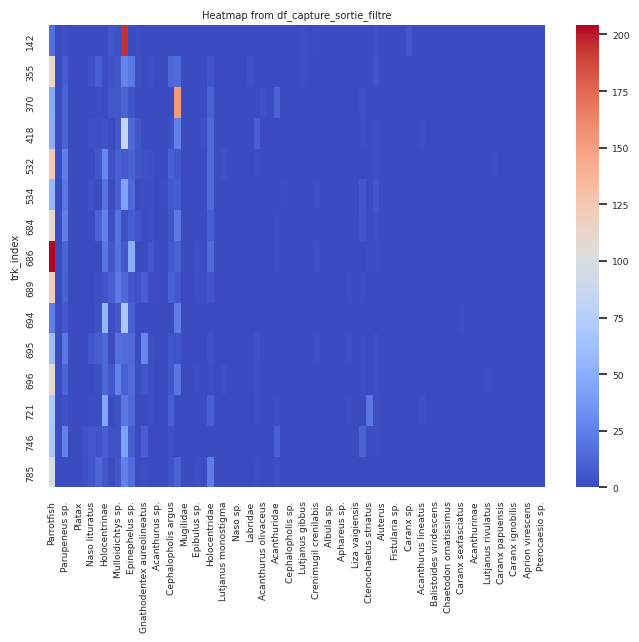

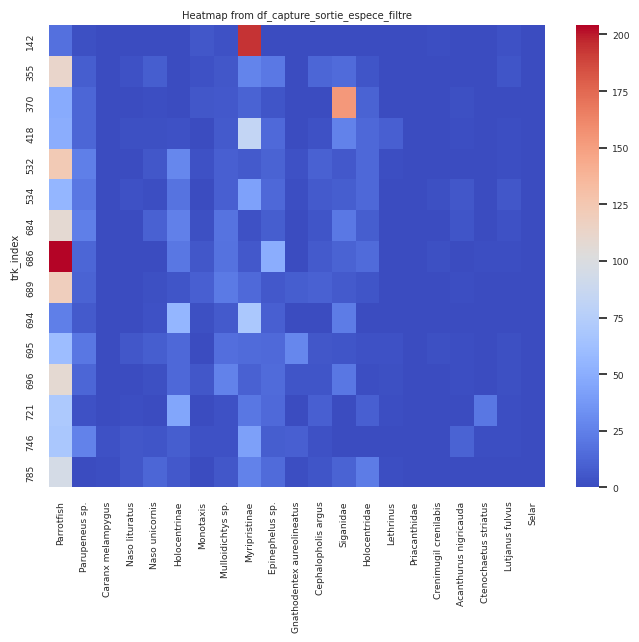

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_capture_sortie_filtre.astype(float), cmap='coolwarm')
plt.title('Heatmap from df_capture_sortie_filtre')
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(df_capture_sortie_espece_filtre.astype(float), cmap='coolwarm')
plt.title('Heatmap from df_capture_sortie_espece_filtre')
plt.show()

#### Avec les fréquences de pêche

In [55]:
# df_capture_freq = df_capture.div(capture_par_sortie['Total'], axis=0)
# print(df_capture_sortie_freq)
df_capture_sortie_espece_freq = df_capture_freq.loc\
 [:, df_capture_freq.columns.intersection(capture_par_espece_order.query('Total >= 100').index)]  #Sélec espèces pêchées +/- de ... en tout
df_capture_sortie_espece_freq = df_capture_sortie_espece_freq.loc\
 [df_capture_sortie_espece_freq.index.isin(capture_par_sortie.query('Total >= 200').index)]   # Sélec les sorties à plus de ... captures
print(df_capture_sortie_espece_freq.shape)

(15, 28)


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 800x600 with 0 Axes>

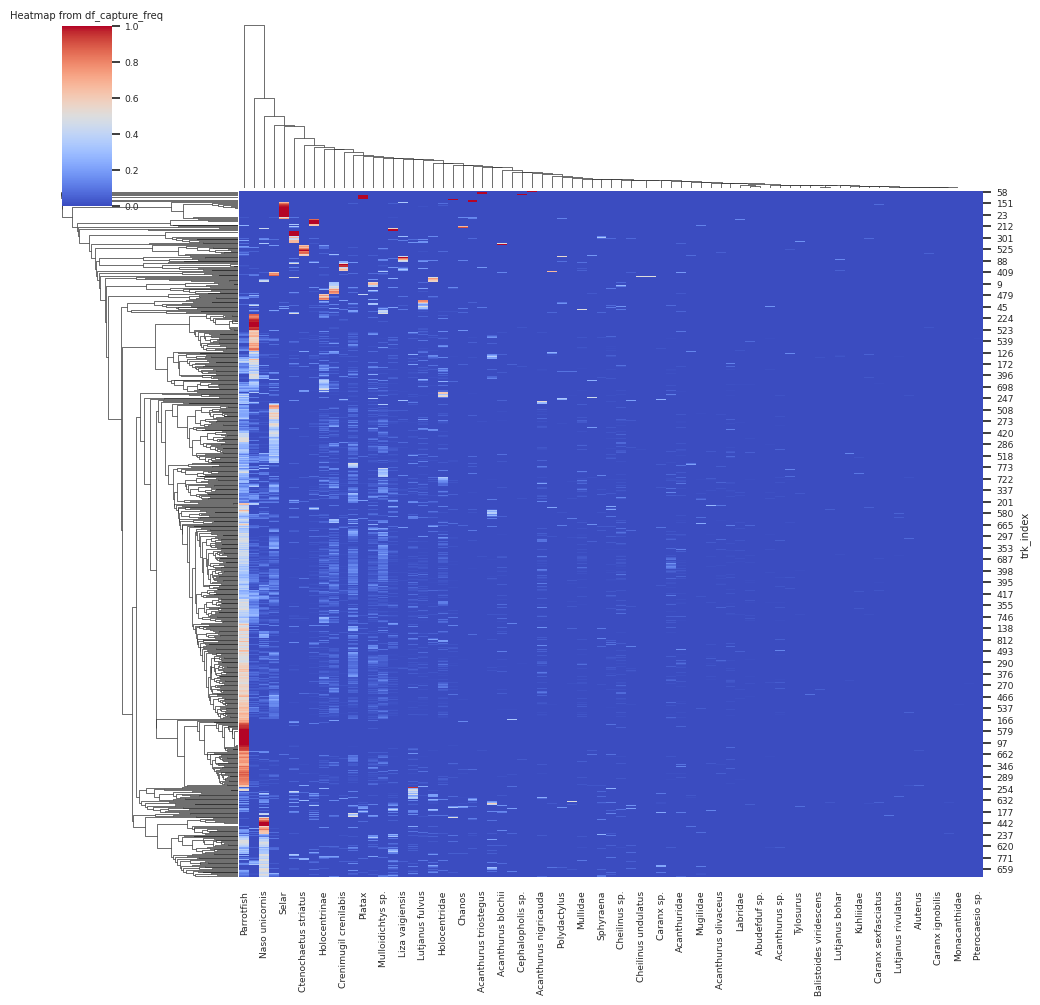

"\nplt.figure(figsize=(8, 6))\nsns.heatmap(df_capture_sortie_espece_freq.astype(float), cmap='coolwarm')\nplt.title('Heatmap from df_capture_sortie_espece_freq')\nplt.show()\n"

In [56]:

plt.figure(figsize=(8, 6))
sns.clustermap(df_capture_freq.astype(float), cmap='coolwarm')
plt.title('Heatmap from df_capture_freq')
plt.show()
'''
plt.figure(figsize=(8, 6))
sns.heatmap(df_capture_sortie_espece_freq.astype(float), cmap='coolwarm')
plt.title('Heatmap from df_capture_sortie_espece_freq')
plt.show()
'''

### Par ratio jour/nuit

#### Global

     dayNightRatio
0         1.000000
1         1.000000
2         0.905882
3         1.000000
4         1.000000
..             ...
753       1.000000
790       1.000000
791       1.000000
803       1.000000
818       1.000000

[212 rows x 1 columns]
(212, 75)


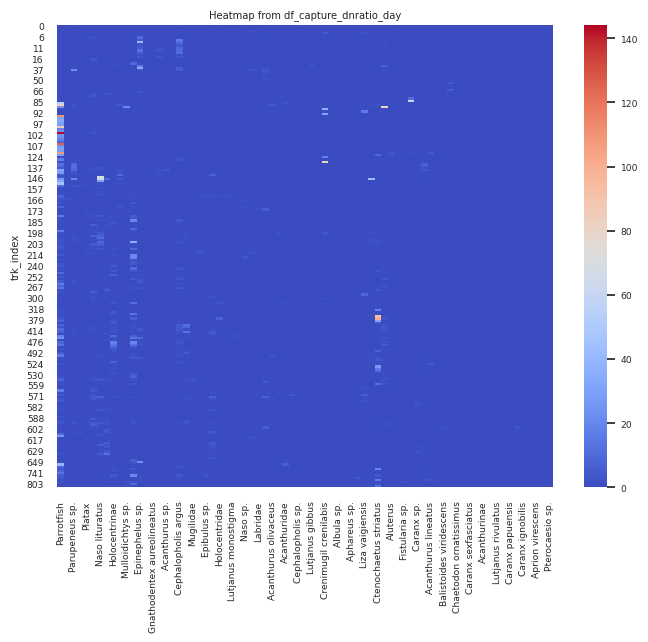

     dayNightRatio
17        0.000000
18        0.000000
19        0.000000
21        0.000000
22        0.000000
..             ...
831       0.000000
832       0.000000
833       0.000000
834       0.000000
835       0.049618

[551 rows x 1 columns]
(551, 75)


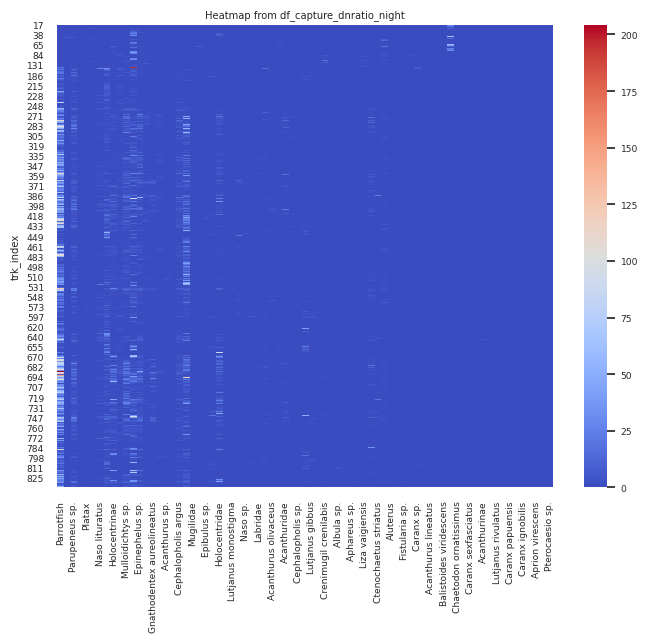

In [57]:
df_dnratio = df_sorties["dayNightRatio"].to_frame(name='dayNightRatio')


df_dnratio_day = df_dnratio.query('dayNightRatio >= 0.9')
print(df_dnratio_day)
df_capture_dnratio_day = df_capture.loc\
 [df_capture.index.isin(df_dnratio_day.index)]
print(df_capture_dnratio_day.shape)

plt.figure(figsize=(8, 6))
sns.heatmap(df_capture_dnratio_day.astype(float), cmap='coolwarm')
plt.title('Heatmap from df_capture_dnratio_day')
plt.show()

df_dnratio_night = df_dnratio.query('dayNightRatio <= 0.1')
print(df_dnratio_night)
df_capture_dnratio_night = df_capture.loc\
 [df_capture.index.isin(df_dnratio_night.index)]
print(df_capture_dnratio_night.shape)

plt.figure(figsize=(8, 6))
sns.heatmap(df_capture_dnratio_night.astype(float), cmap='coolwarm')
plt.title('Heatmap from df_capture_dnratio_night')
plt.show()

#### Selec de sorties et/ou espèces

(20, 28)


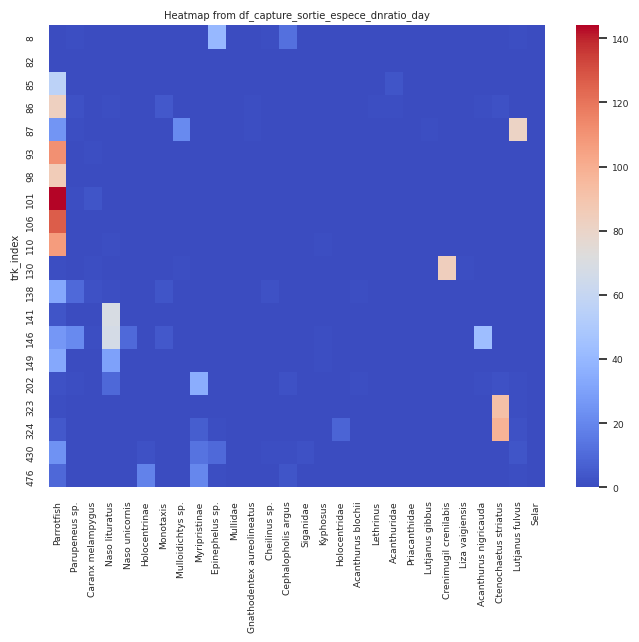

In [58]:
df_capture_espece_dnratio_day = df_capture_dnratio_day.loc\
 [:, df_capture_dnratio_day.columns.intersection(capture_par_espece_order.query('Total >= 100').index)]

df_capture_sortie_espece_dnratio_day = df_capture_espece_dnratio_day.loc\
 [df_capture_espece_dnratio_day.index.isin(capture_par_sortie.query('Total >= 50').index)]   # Sélec les sorties à plus de ... captures

print(df_capture_sortie_espece_dnratio_day.shape)

plt.figure(figsize=(8, 6))
sns.heatmap(df_capture_sortie_espece_dnratio_day.astype(float), cmap='coolwarm')
plt.title('Heatmap from df_capture_sortie_espece_dnratio_day')
plt.show()

(15, 28)


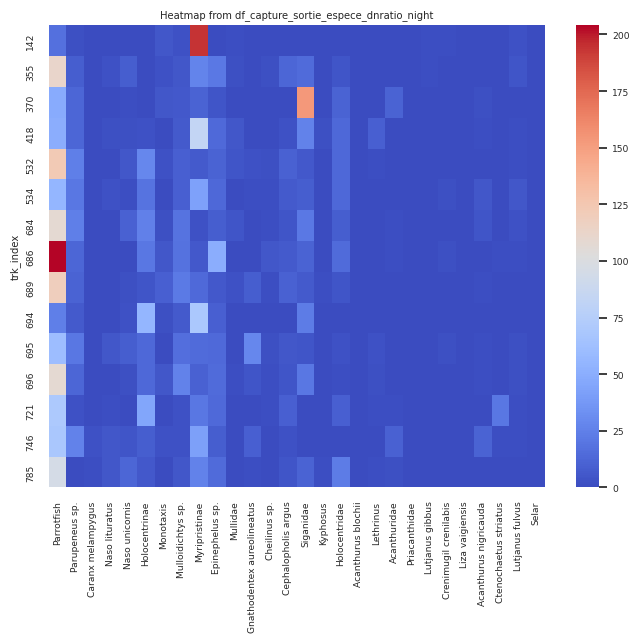

In [59]:
df_capture_espece_dnratio_night = df_capture_dnratio_night.loc\
 [:, df_capture_dnratio_night.columns.intersection(capture_par_espece_order.query('Total >= 100').index)]

df_capture_sortie_espece_dnratio_night = df_capture_espece_dnratio_night.loc\
 [df_capture_espece_dnratio_night.index.isin(capture_par_sortie.query('Total >= 200').index)]   # Sélec les sorties à plus de ... captures

print(df_capture_sortie_espece_dnratio_night.shape)

plt.figure(figsize=(8, 6))
sns.heatmap(df_capture_sortie_espece_dnratio_night.astype(float), cmap='coolwarm')
plt.title('Heatmap from df_capture_sortie_espece_dnratio_night')
plt.show()


# Visualisations en fonction de la technique avec différentes métriques

In [60]:
# # DNratio_spear = df_sorties[df_sorties['Gear']=="spear"].query('0.8 >= dayNightRatio >= 0.2')['dayNightRatio'].sort_values()
# DNratio_spear = df_sorties[(df_sorties['Gear']=="spear_night") | (df_sorties['Gear']=="spear_day")]['dayNightRatio'].sort_values()
# plt.plot(np.arange(len(DNratio_spear)), DNratio_spear)

In [61]:
# print(df_sorties[["trk_id","Gear"]])
# print(liste_sorties_distinctes)
# print(df_capture_trk)

In [62]:
# df_capture_technique = pd.merge(df_sorties[["trk_id","Gear"]], df_capture_trk, on='trk_id', how='inner')
# df_technique = df_capture_technique[["trk_id","Gear"]]
# print(df_capture_technique)

## Global

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


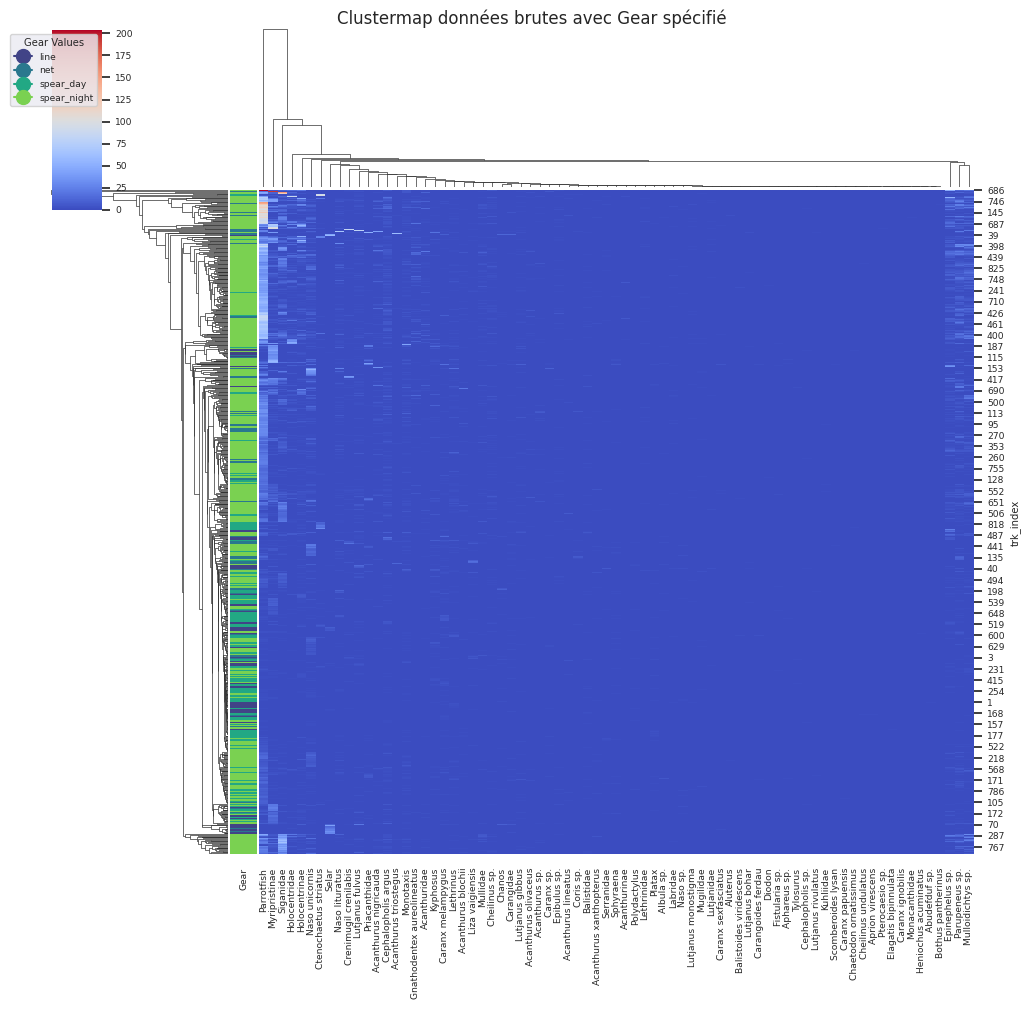

In [63]:
column_name = 'Gear'

# Utiliser une colormap personnalisée basée sur les valeurs de la colonne spécifiée
# lut = dict(zip(df_sorties[column_name].unique(), "rbg"))
lut = dict(zip(df_sorties[column_name].unique(), sns.color_palette("viridis", n_colors=len(df_sorties[column_name].unique()))))
row_colors = df_sorties[column_name].map(lut)

# Créer le clustermap avec les couleurs de ligne basées sur la colonne spécifiée
# sns.set(style="whitegrid")
sns.set(font_scale=0.6)
cluster = sns.clustermap(df_capture.astype(float), row_colors=row_colors, cmap="coolwarm", xticklabels = True)

# Ajouter une légende pour les couleurs de ligne
legend_labels_colors = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10) for label, color in lut.items()]
plt.legend(handles=legend_labels_colors, title=f'{column_name.capitalize()} Values', loc='best')

# Afficher le clustermap
plt.suptitle('Clustermap données brutes avec Gear spécifié',fontsize=12, x=0.5, y=1)
plt.show()

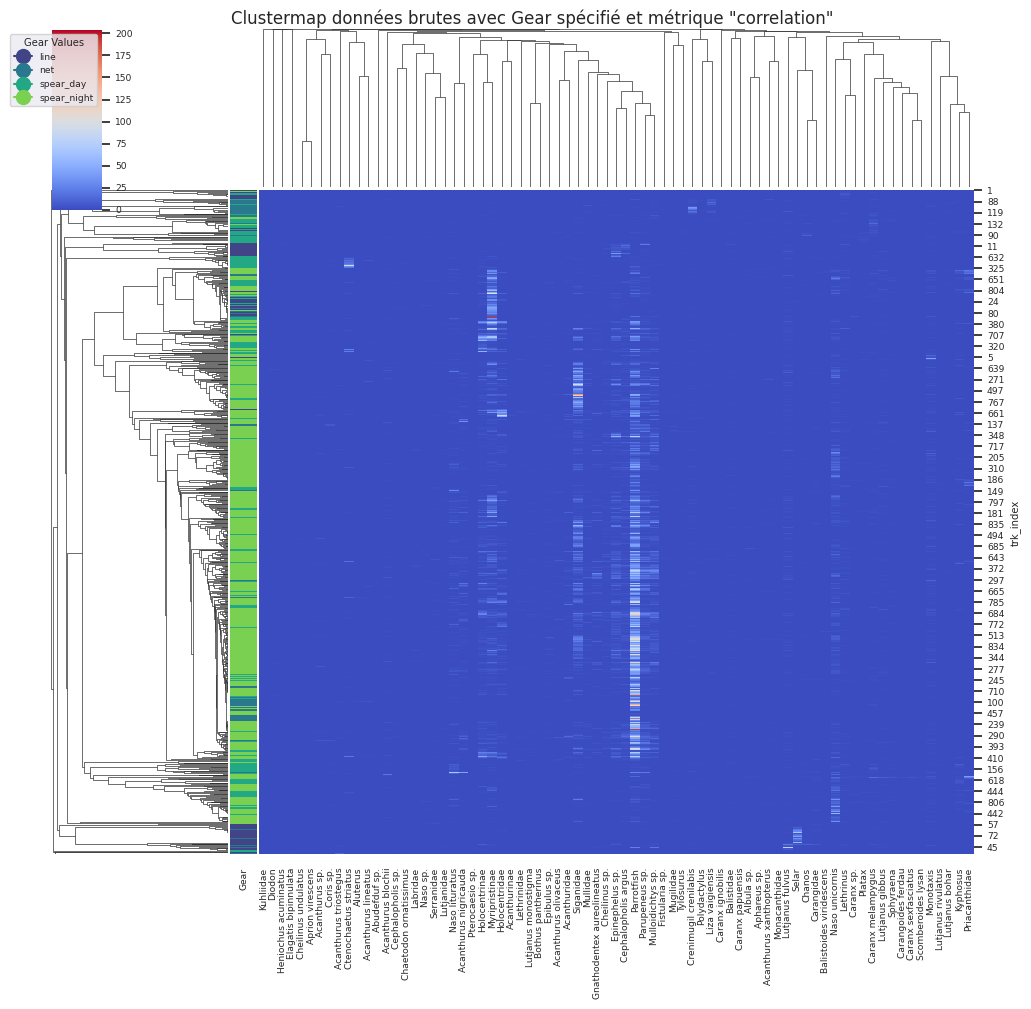

In [64]:
cluster = sns.clustermap(df_capture.astype(float), row_colors=row_colors, cmap="coolwarm", xticklabels = True, metric="correlation")
# cluster = sns.clustermap(df_capture.astype(float), row_colors=row_colors, cmap="coolwarm", xticklabels = True, metric="braycurtis", method="average")

# Ajouter une légende pour les couleurs de ligne
legend_labels_colors = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10) for label, color in lut.items()]
plt.legend(handles=legend_labels_colors, title=f'{column_name.capitalize()} Values', loc='best')

# Afficher le clustermap
plt.suptitle('Clustermap données brutes avec Gear spécifié et métrique "correlation"',fontsize=12, x=0.5, y=1)
plt.show()

## Par fréquence par sortie

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


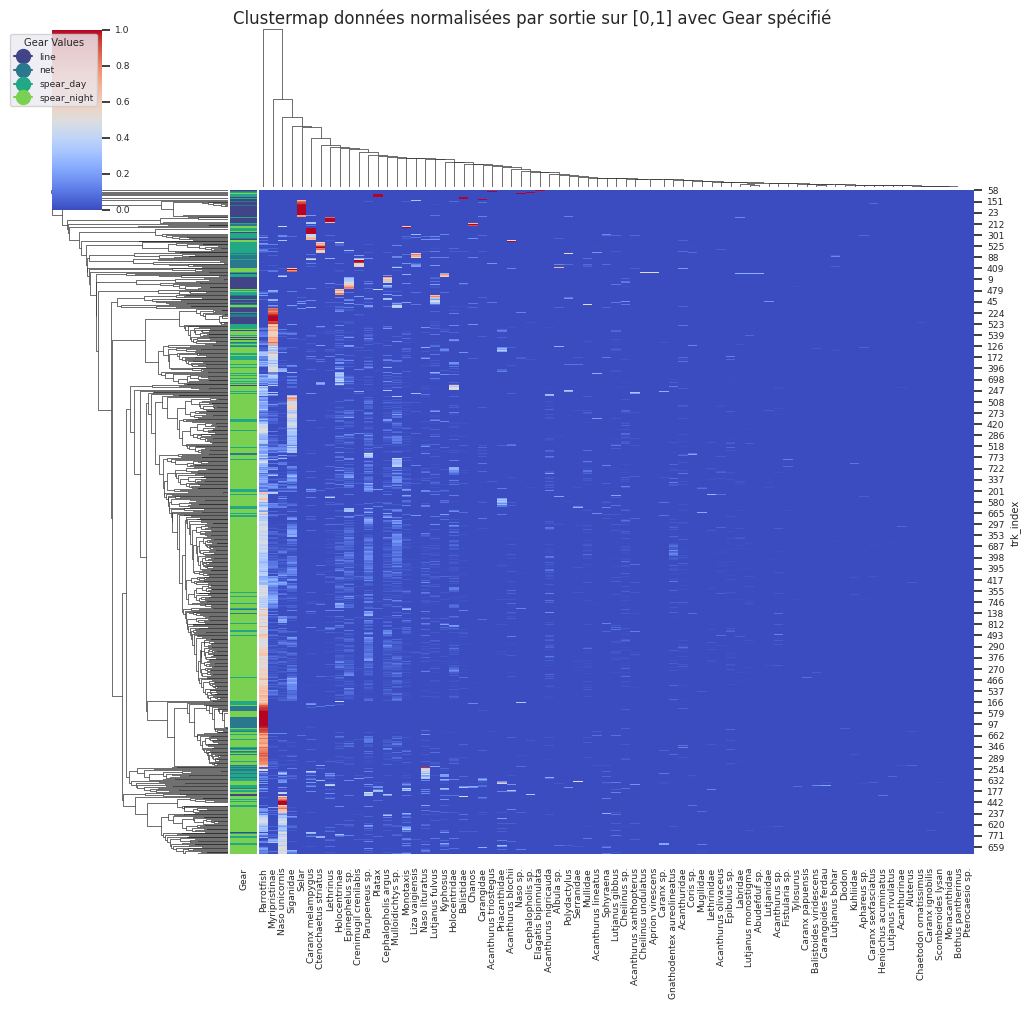

In [65]:
# On regarde pour chaque sortie la fréquence de capture de chaque espèce

column_name = 'Gear'

# Utiliser une colormap personnalisée basée sur les valeurs de la colonne spécifiée
# lut = dict(zip(df_sorties[column_name].unique(), "rbg"))
lut = dict(zip(df_sorties[column_name].unique(), sns.color_palette("viridis", n_colors=len(df_sorties[column_name].unique()))))
row_colors = df_sorties[column_name].map(lut)

# Créer le clustermap avec les couleurs de ligne basées sur la colonne spécifiée
# sns.set(style="whitegrid")
sns.set(font_scale=0.6)
cluster = sns.clustermap(df_capture_freq.astype(float), row_colors=row_colors, cmap="coolwarm", xticklabels = True)

# Ajouter une légende pour les couleurs de ligne
legend_labels_colors = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10) for label, color in lut.items()]
plt.legend(handles=legend_labels_colors, title=f'{column_name.capitalize()} Values', loc='best')

# Afficher le clustermap
plt.suptitle('Clustermap données normalisées par sortie sur [0,1] avec Gear spécifié',fontsize=12, x=0.5, y=1)
plt.show()

In [66]:
print(df_capture_freq.columns)

Index(['Parrotfish', 'Serranidae', 'Parupeneus sp.', 'Sphyraena', 'Platax',
       'Caranx melampygus', 'Naso lituratus', 'Naso unicornis',
       'Holocentrinae', 'Monotaxis', 'Mulloidichtys sp.', 'Myripristinae',
       'Epinephelus sp.', 'Mullidae', 'Gnathodentex aureolineatus',
       'Cheilinus sp.', 'Acanthurus sp.', 'Lutjanidae', 'Cephalopholis argus',
       'Siganidae', 'Mugilidae', 'Chanos', 'Epibulus sp.', 'Kyphosus',
       'Holocentridae', 'Polydactylus', 'Lutjanus monostigma',
       'Acanthurus blochii', 'Naso sp.', 'Balistidae', 'Labridae', 'Lethrinus',
       'Acanthurus olivaceus', 'Carangidae', 'Acanthuridae',
       'Acanthurus xanthopterus', 'Cephalopholis sp.', 'Priacanthidae',
       'Lutjanus gibbus', 'Kuhliidae', 'Crenimugil crenilabis', 'Tylosurus',
       'Albula sp.', 'Lutjanus bohar', 'Aphareus sp.', 'Lethrinidae',
       'Liza vaigiensis', 'Acanthurus nigricauda', 'Ctenochaetus striatus',
       'Lutjanus fulvus', 'Aluterus', 'Abudefduf sp.', 'Fistularia s

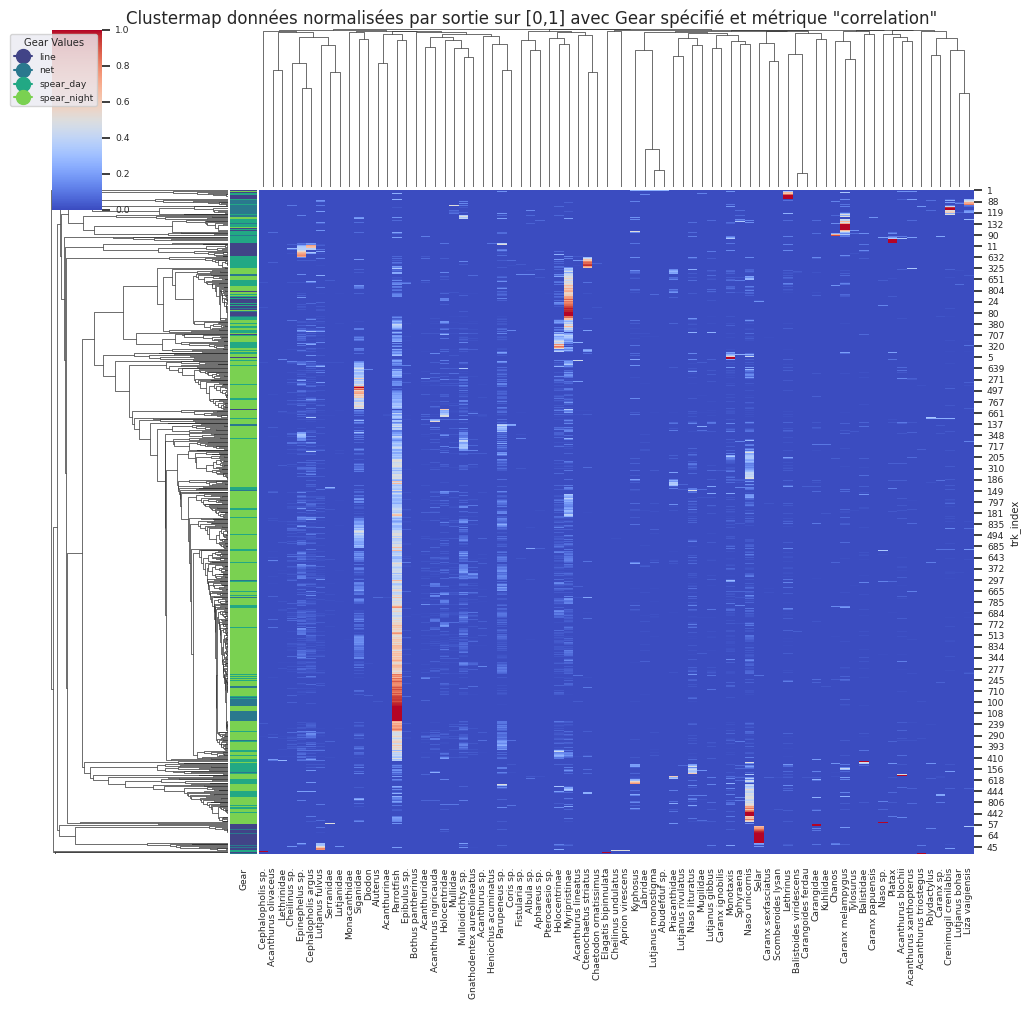

In [67]:
cluster = sns.clustermap(df_capture_freq.astype(float), row_colors=row_colors, cmap="coolwarm", xticklabels = True, metric="correlation")
# df_mauvaises_sorties = df_sorties[~df_sorties['Gear'].isin({'line', 'net', 'spear'})]

# Ajouter une légende pour les couleurs de ligne
legend_labels_colors = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10) for label, color in lut.items()]
plt.legend(handles=legend_labels_colors, title=f'{column_name.capitalize()} Values', loc='best')

# Afficher le clustermap
plt.suptitle('Clustermap données normalisées par sortie sur [0,1] avec Gear spécifié et métrique "correlation"',fontsize=12, x=0.5, y=1)
plt.show()

# Visualisation avec données spatiales

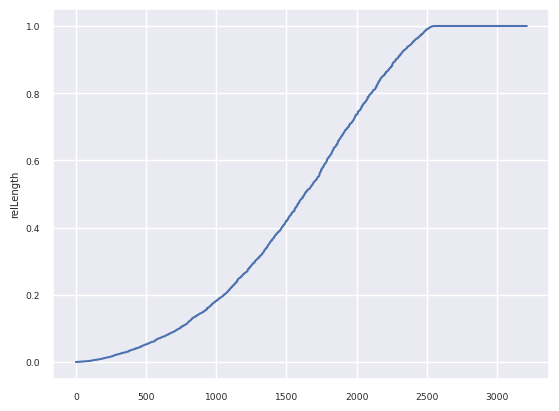

In [68]:
relLenght = df_habitat_total.query('1 >= relLength > 0')['relLength'].sort_values()
plt.ylabel("relLength")
plt.plot(np.arange(len(relLenght)), relLenght)

Il y a peu de sorties qui se sont déroulées dans différents habitats de manière équilibrée. On peut en première approximation considérer que l'habitat de la sortie est celui où elle a passsé le plus de temps.

In [69]:
# idx_max_time = df_habitat_total.groupby('trk_id')['relLength'].idxmax()
# idx_max = set(idx_max_time.values.astype(int)) & set(df_habitat_total.index)
# # certaines sorties n'ont pas de données et donnent des indices impossibles dans idx_max_time

# # print(idx_max_time)
# print(len(idx_max))
# print(df_habitat_total)

# # Sélectionner uniquement les lignes correspondant à l'habitat avec le relLength maximum
# df_habitat = df_habitat_total.loc[idx_max]

# # Réinitialiser l'index si nécessaire
# df_habitat.reset_index(drop=True, inplace=True)

# # Afficher le résultat
# # print(result_df[result_df['trk_id'] == 'TV003_98'])
# print(df_habitat)

# Obtenir les représentants uniques et leur fréquence
valeurs_uniques = df_habitat['habitat'].value_counts()
habitats_uniques = valeurs_uniques.reset_index()
habitats_uniques.columns = ['Représentant', 'Fréquence']
print("Représentants uniques des habitats et leur fréquence :")
print(habitats_uniques)

Représentants uniques des habitats et leur fréquence :
  Représentant  Fréquence
0     BackReef        788
1     Fringing        291
2      LagDeep        238
3     ForeReef        169
4         Pass        131
5          out         32


alors df_capture_habitat = un dataframe avec trk_id, habitat unique principal, et les types de poissons capturés, cette table est nettoyée

In [70]:
# df_habitat_order = pd.merge(liste_sorties_distinctes, df_habitat, on='trk_id', how='left')
# df_habitat_order = df_habitat_order[["trk_id","habitat"]]

# df_capture_habitat = pd.merge(df_habitat_order, df_capture_trk, on='trk_id', how='outer')
# df_capture_habitat = df_capture_habitat.dropna(subset = ['habitat'])

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


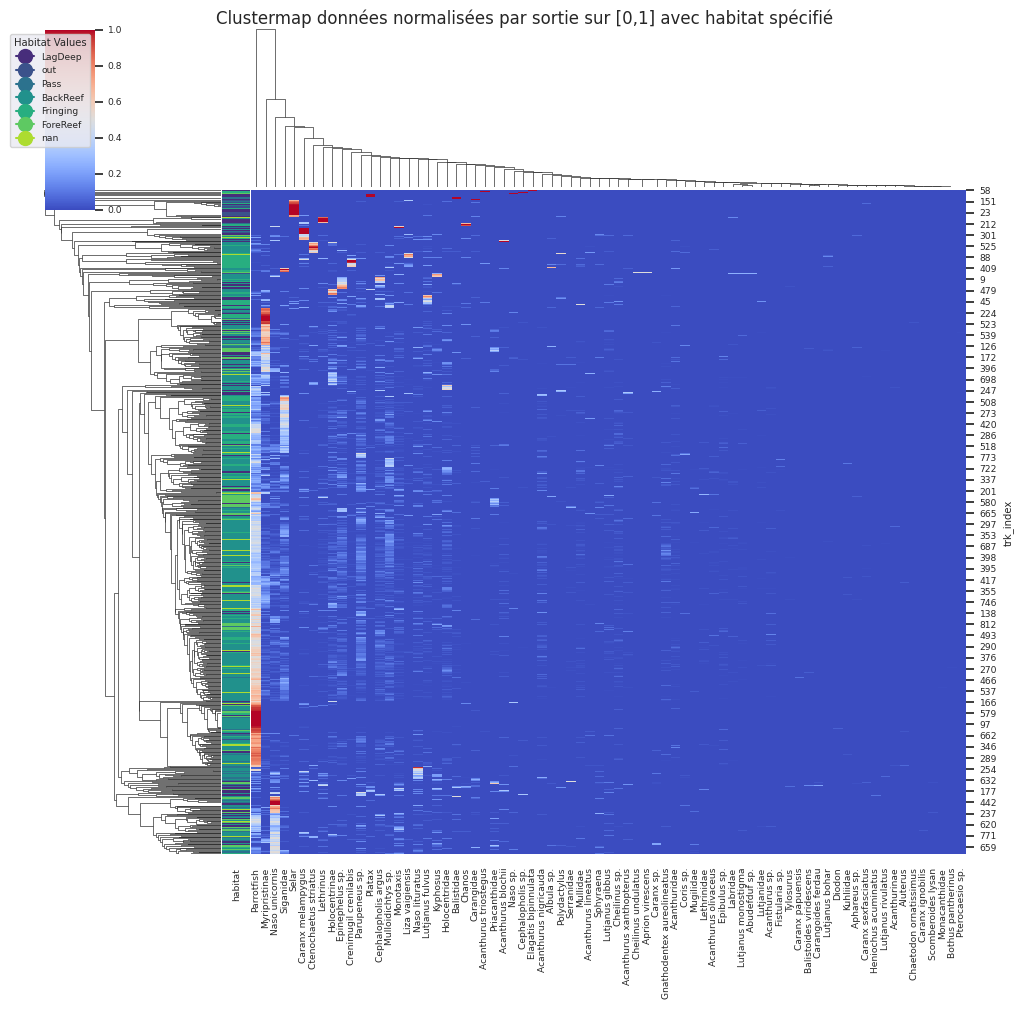

In [71]:
column_name = 'habitat'

# Utiliser une colormap personnalisée basée sur les valeurs de la colonne spécifiée
# lut = dict(zip(df_sorties[column_name].unique(), "rbg"))
lut = dict(zip(df_habitat_order[column_name].unique(), sns.color_palette("viridis", n_colors=len(df_habitat_order[column_name].unique()))))
row_colors = df_habitat_order[column_name].map(lut)

# Créer le clustermap avec les couleurs de ligne basées sur la colonne spécifiée
# sns.set(style="whitegrid")
sns.set(font_scale=0.6)
cluster = sns.clustermap(df_capture_freq.astype(float), row_colors=row_colors, cmap="coolwarm", xticklabels = True)

# Ajouter une légende pour les couleurs de ligne
legend_labels_colors = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10) for label, color in lut.items()]
plt.legend(handles=legend_labels_colors, title=f'{column_name.capitalize()} Values', loc='best')

# Afficher le clustermap
plt.suptitle('Clustermap données normalisées par sortie sur [0,1] avec habitat spécifié',fontsize=12, x=0.5, y=1)
plt.show()

In [72]:
donnees = cluster.data2d.values
index_labels = cluster.dendrogram_row.reordered_ind
column_labels = cluster.dendrogram_col.reordered_ind

donnees = pd.DataFrame(donnees, index=df_capture.index[index_labels], columns=df_capture.columns[column_labels])
# print(donnees)

# Déterminants physico-biologiques (types d’habitats lagonaires)

## Nombre de poissons pêchés par sortie dans chaque type lagunaire

In [73]:
# print(df_capture_habitat)

On va déterminer quel poisson vit dans quel habitat :
méthode on regarde l'habitat principal visité lors d'une sortie, et on regarde la quantité brute par pêche (proportion pêchée d'une espèce par pêcherie) on fait le pourcentage par habitat de sortie au total sur toutes les pêches

## Habitat par poisson

On va donner l'habitat principale par espèce de poisson, dans un premier temps nous ne considérerons que les espèces facilement spécifiable à un certain type d'habitat et nous les y contraindrons dans la suite.
Il se pourrait que certaines espèces soient présentes dans plusieurs habitats

In [74]:
df_capture_habitat_grp = df_capture_habitat.groupby('habitat')
somme_par_espece = df_capture_habitat_grp.sum()

#On regarde que les pêches ayant pris un nombre minimal de poisson pour que le comptage puisse etre utilisable.
nb_prises_min = 600
colonnes_relevent = somme_par_espece.loc[:,somme_par_espece.sum() > nb_prises_min]

#On regarde le pourcentage de prise par environnement
pourcent_par_espece_relevent = colonnes_relevent/colonnes_relevent.sum()

#On regarde les espèces qui sont en fonction d'un niveau de spécification par habitat
specification = 0.6
colonnes_specifie = pourcent_par_espece_relevent.loc[:, (pourcent_par_espece_relevent > specification).any()]

# print(colonnes_specifie)

# Si on est à un niveau de spécification assez élevé au moins > 50%, on peut prendre un habitat et dire que ce poisson est uniquement présent dans cet habitat
dico_habitat_poisson = {}
for hab in colonnes_specifie.index :
  dico_habitat_poisson[hab] = []

for poisson in colonnes_specifie.columns :
  for hab in colonnes_specifie.index :
    if hab == colonnes_specifie[poisson].idxmax():
      dico_habitat_poisson[hab].append(poisson)

dico_poisson_habitat = {}
for poisson in colonnes_specifie.columns:
  dico_poisson_habitat[poisson] = colonnes_specifie[poisson].idxmax()

print(dico_habitat_poisson)
print(dico_poisson_habitat)


{'BackReef': ['Parrotfish', 'Parupeneus sp.', 'Holocentrinae', 'Mulloidichtys sp.', 'Myripristinae', 'Epinephelus sp.', 'Cephalopholis argus', 'Siganidae', 'Holocentridae'], 'ForeReef': [], 'Fringing': [], 'LagDeep': [], 'Pass': [], 'out': []}
{'Parrotfish': 'BackReef', 'Parupeneus sp.': 'BackReef', 'Holocentrinae': 'BackReef', 'Mulloidichtys sp.': 'BackReef', 'Myripristinae': 'BackReef', 'Epinephelus sp.': 'BackReef', 'Cephalopholis argus': 'BackReef', 'Siganidae': 'BackReef', 'Holocentridae': 'BackReef'}


<ipython-input-74-a44b427cb663>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  somme_par_espece = df_capture_habitat_grp.sum()


In [75]:
# print("somme_par_espece :")
# print(somme_par_espece)
# print("colonnes_relevent :")
# print(colonnes_relevent)
# print("pourcent_par_espece_relevent :")
# print(pourcent_par_espece_relevent)

In [76]:
#dans les observations de en normalisation m0v1 nous avions dit qu'une liste d'espèce pouvait interagir, pour cela il faudrait au moins qu'il soient
#pêchable dans le même endroit, ce qui est vrai

liste = ['Siganidae', 'Mullidae','Gnathodentex aureolineatus','Cheilinus sp.', 'Epinephelus sp.', 'Cephalopholis argus', 'Parrotfish', 'Parupeneus sp.', 'Mulloidichtys sp.']

for poisson in liste :
  if poisson in colonnes_specifie.columns:
    print(f"{poisson} est dans -{dico_poisson_habitat[poisson]}")
  else :
    print(f"{poisson} n'est pas spécifiable")




Siganidae est dans -BackReef
Mullidae n'est pas spécifiable
Gnathodentex aureolineatus n'est pas spécifiable
Cheilinus sp. n'est pas spécifiable
Epinephelus sp. est dans -BackReef
Cephalopholis argus est dans -BackReef
Parrotfish est dans -BackReef
Parupeneus sp. est dans -BackReef
Mulloidichtys sp. est dans -BackReef


# Evolution temporelle

On va essayer dans cette partie de voir les evolutions temporelles des populations de poisson

## bases de donnée considérées

In [77]:
# habitat = '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Lev3_Geographie/trackClassification_by_habitat.csv'

# df_habitat_total = pd.read_csv(habitat, sep=';', decimal=',')

# valeurs_uniques = df_habitat_total['trk_id'].unique()

# idx_max_time = df_habitat_total.groupby('trk_id')['relLength'].idxmax()
# idx_max = set(idx_max_time.values.astype(int)) & set(df_habitat_total.index)
# # certaines sorties n'ont pas de données et donnent des indices impossibles dans idx_max_time

# # Sélectionner uniquement les lignes correspondant à l'habitat avec le relLength maximum
# df_habitat = df_habitat_total.loc[idx_max]

# # Réinitialiser l'index si nécessaire
# df_habitat.reset_index(drop=True, inplace=True)
# df_habitat_order = pd.merge(liste_sorties_distinctes, df_habitat, on='trk_id', how='inner')
# df_habitat_order = df_habitat_order[["trk_id","habitat"]]
# # print(df_habitat_order)
# # print(df_capture)
# # print(df_capture_trk)
# df_capture_habitat = pd.merge(df_habitat_order, df_capture_trk, on='trk_id', how='outer')
# df_capture_habitat = df_capture_habitat.dropna(subset = ['habitat'])

<ipython-input-78-e440810ee6f3>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_Data_grouped = df_Data.groupby('newDate').sum()


       newDate  Inf_ID
0   2018-09-11       1
1   2018-09-28       1
2   2018-10-15       1
3   2018-10-16       1
4   2018-10-17       1
..         ...     ...
391 2021-05-17       1
392 2021-05-18       2
393 2021-05-20       1
394 2021-05-22       1
395 2021-06-04       1

[396 rows x 2 columns]
2


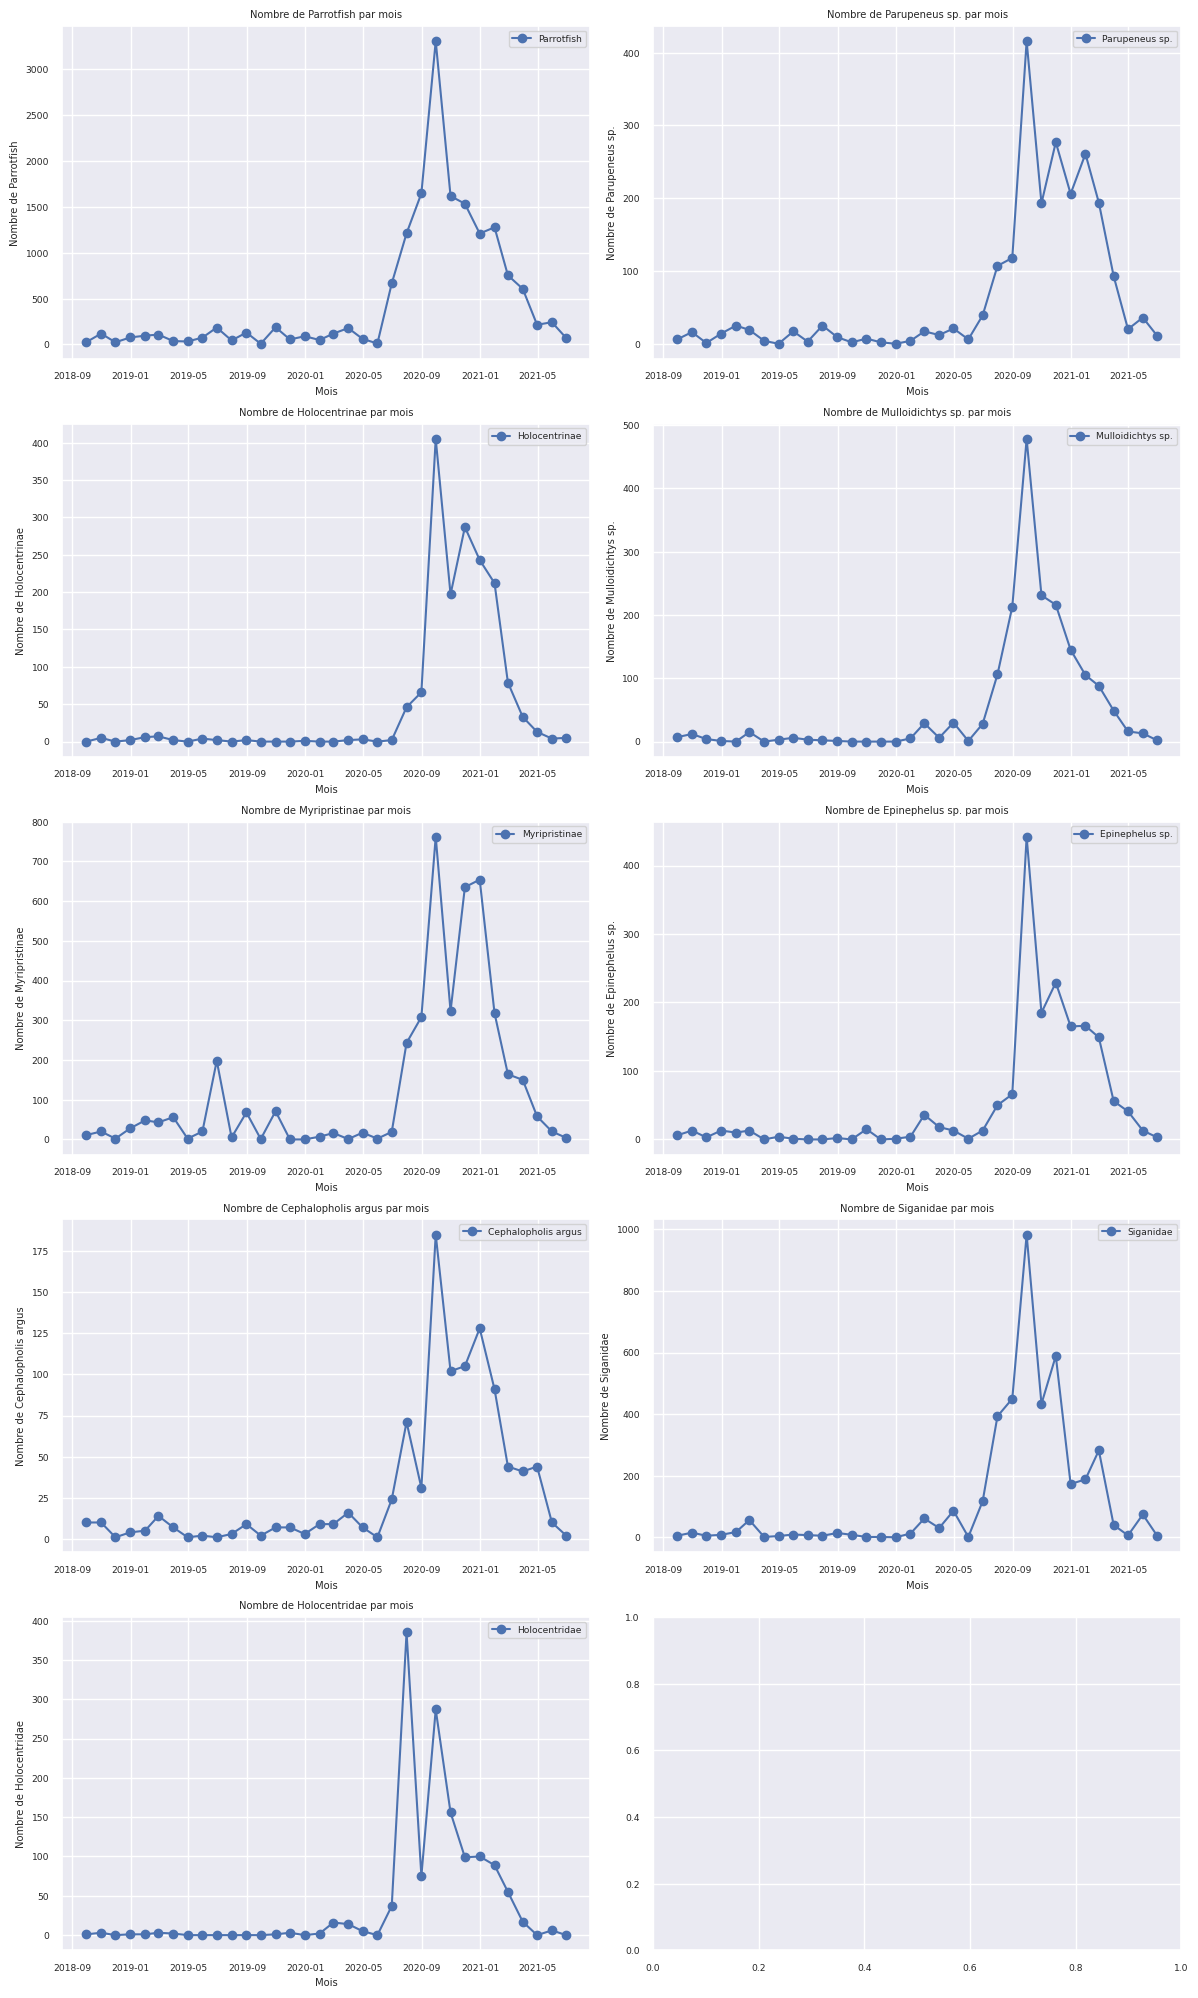

In [78]:
#df_capture_trk contient les track_id et les especes pêchées

Date = '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Lev2-SortiesPeches.xlsx'

df_dossier_2 = pd.read_excel(Date)
df_Date = df_dossier_2[['trk_id', 'newDate', 'Inf_ID']]
df_Data = pd.merge(df_Date, df_capture_trk, on='trk_id', how='inner')

df_Data.dropna(inplace = True)
df_Data['newDate'] = pd.to_datetime(df_Data['newDate'])

df_Data_grouped = df_Data.groupby('newDate').sum()
df_Data_grouped['Date'] = df_Data_grouped.index
df_Data_sorted = df_Data_grouped.sort_values(by='Date', ascending=True)
df_Data_sorted.reset_index(drop=True, inplace=True)

# print(df_Data_sorted.columns)
#################################################################################
espece = "Holocentridae"

df_Data_sorted['Date']=pd.to_datetime(df_Data_sorted['Date'])
# x = df_Data_sorted['Date'].values.astype(np.int64) // 10 ** 9
x = df_Data_sorted['Date']
y=df_Data_sorted['Parrotfish']

# Regrouper par mois et calculer la somme du nombre de Parrotfish par mois
df_monthly = df_Data_sorted.resample('M', on='Date').sum()


# Liste des espèces à inclure dans le graphique
species_to_plot = dico_habitat_poisson['BackReef']

# Définir le nombre de lignes et de colonnes pour les sous-graphiques
num_rows = len(species_to_plot) // 2  + 1# Division entière pour obtenir le nombre de lignes
num_cols =  2 # Deux colonnes

# Créer la disposition de sous-graphiques
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# Tracé des graphiques pour chaque espèce dans son subplot respectif
for i, species in enumerate(species_to_plot):
    row = i // num_cols  # Calcul de la ligne
    col = i % num_cols  # Calcul de la colonne
    ax = axes[row, col] if num_rows > 1 else axes[col]  # Gestion du cas où il n'y a qu'une seule ligne
    ax.plot(df_monthly.index, df_monthly[species], marker='o', linestyle='-', label=species)
    ax.set_title(f'Nombre de {species} par mois')
    ax.set_xlabel('Mois')
    ax.set_ylabel(f'Nombre de {species}')
    ax.legend()

# Ajustement automatique de l'espacement entre les sous-graphiques pour éviter les chevauchements
plt.tight_layout()

# Affichage des sous-graphiques
# plt.show()



# Regrouper par date et compter les valeurs distinctes de 'VotreColonne'
result = df_Data.groupby('newDate')['Inf_ID'].nunique().reset_index()

# Renommer la colonne résultante
result = result.rename(columns={'VotreColonne': 'Nombre de Valeurs Distinctes'})

# Afficher le résultat
print(result)

sum=0
for k in result.index :
  if result.loc[k]['Inf_ID'] >=10:
    sum+=1
print(sum)

Bon ptet il faut aussi normaliser par le nombre de participants à l'étude parce que là c'est pas très logique

# Création d'une base de données utilisable pour R et python

In [79]:
Lev2 = '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Lev2-SortiesPeches.xlsx'
Lev3_geo ='/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Lev3_Geographie/trackClassification_by_habitat.xlsx'

df_Lev2 = pd.read_excel(Lev2)
df_Lev2 = df_Lev2[['trk_id', 'dayNightRatio', 'moonDay','moonDur']]
df_Data_R = pd.merge(df_Lev2, df_capture_habitat, on='trk_id', how='inner')

df_Data_R.dropna(inplace = True)
df_Data_R = df_Data_R.drop(columns=['habitat'])

df_Data_R_BR_ini = pd.merge(df_Data_R, df_habitat_order, on='trk_id', how='inner')

df_Data_R_BR = df_Data_R_BR_ini[df_Data_R_BR_ini['habitat'] == 'BackReef']

df_Data_R_BR = df_Data_R_BR.drop(columns=['trk_id','habitat'])

print(df_Data_R_BR)

     dayNightRatio  moonDay  moonDur  Parrotfish  Serranidae  Parupeneus sp.  \
7         1.000000       19      0.0         0.0         0.0             0.0   
11        0.986885       14      0.0         0.0         0.0             0.0   
13        0.973333        5      4.0         0.0         0.0             0.0   
24        0.000000       25      0.0         0.0         0.0             0.0   
25        0.000000       28      0.0         0.0         0.0             0.0   
..             ...      ...      ...         ...         ...             ...   
796       0.000000       14    415.0        37.0         0.0            18.0   
797       0.000000       18    236.0         2.0         0.0             0.0   
798       0.000000       13    390.0         9.0         0.0             1.0   
799       0.000000       19    184.0        13.0         0.0             5.0   
800       0.000000       26      0.0        51.0         0.0             4.0   

     Sphyraena  Platax  Caranx melampyg

In [80]:
import shutil
df_Data_R_BR.to_csv('/content/Data_R.csv', index=False)
shutil.copy('/content/Data_R.csv', '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Data_R.csv')

'/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Data_R.csv'

Base de données à exporter avec tous les paramètres :

In [81]:
Lev2 = '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Lev2-SortiesPeches.xlsx'

df_Lev2 = pd.read_excel(Lev2)
df_Lev2 = df_Lev2[['trk_id', 'Inf_ID', 'dayNightRatio', 'dayMinutes', 'nightMinutes', 'moonDay','moonDur', 'moonPhase']]

df_Data_R_total = pd.merge(df_Lev2, df_capture_total, on='trk_id', how='inner')

df_Data_R_total.dropna(inplace = True)

# df_Data_R = df_Data_R.drop(columns=['trk_id','habitat'])

# print(df_Data_R_total)
df_Data_R_total.to_csv('/content/Data_R_total.csv', index=False)
shutil.copy('/content/Data_R_total.csv', '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Data_R_total.csv')

print(df_Data_R_total.columns)

Index(['trk_id', 'Inf_ID', 'dayNightRatio', 'dayMinutes', 'nightMinutes',
       'moonDay', 'moonDur', 'moonPhase', 'Gear', 'nb_captures', 'nb_especes',
       'passToPass', 'village', 'Coast', 'habitat', 'Parrotfish', 'Serranidae',
       'Parupeneus sp.', 'Sphyraena', 'Platax', 'Caranx melampygus',
       'Naso lituratus', 'Naso unicornis', 'Holocentrinae', 'Monotaxis',
       'Mulloidichtys sp.', 'Myripristinae', 'Epinephelus sp.', 'Mullidae',
       'Gnathodentex aureolineatus', 'Cheilinus sp.', 'Acanthurus sp.',
       'Lutjanidae', 'Cephalopholis argus', 'Siganidae', 'Mugilidae', 'Chanos',
       'Epibulus sp.', 'Kyphosus', 'Holocentridae', 'Polydactylus',
       'Lutjanus monostigma', 'Acanthurus blochii', 'Naso sp.', 'Balistidae',
       'Labridae', 'Lethrinus', 'Acanthurus olivaceus', 'Carangidae',
       'Acanthuridae', 'Acanthurus xanthopterus', 'Cephalopholis sp.',
       'Priacanthidae', 'Lutjanus gibbus', 'Kuhliidae',
       'Crenimugil crenilabis', 'Tylosurus', 'Albula s

In [82]:
# Lev2 = '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Lev2-SortiesPeches.xlsx'

# df_Lev2 = pd.read_excel(Lev2)
# df_Lev2 = df_Lev2[['trk_id', 'Inf_ID', 'dayNightRatio', 'dayMinutes', 'nightMinutes', 'moonDay','moonDur', 'moonPhase']]

# df_Data_R_freq = pd.merge(df_Lev2, df_capture_freq, on='trk_id', how='inner')

# df_Data_R_freq.dropna(inplace = True)

# # df_Data_R = df_Data_R.drop(columns=['trk_id','habitat'])

# # print(df_Data_R_freq)
# df_Data_R_freq.to_csv('/content/Data_R_freq.csv', index=False)
# shutil.copy('/content/Data_R_freq.csv', '/content/drive/MyDrive/MSV_Projet_Polynésie/Données/Data_R_freq.csv')

In [83]:
# print(df_capture_freq)

# Déterminants socio-économiques (techniques de pêche, expertise)

## Technique par poisson

Etudions l'influence de la technique sur la composition des pêches, et éventuellement certaines conjectures sur des comportements de poisson (vie en banc, solitaire, etc.)

In [84]:
# print(df_capture_technique)

In [85]:
df_capture_technique_grp = df_capture_technique.groupby('Gear')
somme_par_espece_tech = df_capture_technique_grp.sum()

#On regarde que les pêches ayant pris un nombre minimal de poisson pour que le comptage puisse etre utilisable.
nb_prises_min = 50
colonnes_relevent = somme_par_espece_tech.loc[:,somme_par_espece_tech.sum() > nb_prises_min]

#On regarde le pourcentage de prise par environnement
pourcent_par_espece = somme_par_espece_tech/somme_par_espece_tech.sum()
pourcent_par_espece_relevent = colonnes_relevent/colonnes_relevent.sum()

#On regarde les espèces qui sont en fonction d'un niveau de spécification par technique
specification = 0.9
colonnes_specifie = pourcent_par_espece_relevent.loc[:, (pourcent_par_espece_relevent > specification).any()]

# print(colonnes_specifie)

# Si on est à un niveau de spécification assez élevé au moins > 50%, on peut prendre un technique
# et dire que ce poisson est uniquement pêché via cette technique
dico_technique_poisson = {}
for tech in colonnes_specifie.index :
  dico_technique_poisson[tech] = []

for poisson in colonnes_specifie.columns :
  for tech in colonnes_specifie.index :
    if tech == colonnes_specifie[poisson].idxmax():
      dico_technique_poisson[tech].append(poisson)

dico_poisson_technique = {}
for poisson in colonnes_specifie.columns:
  dico_poisson_technique[poisson] = colonnes_specifie[poisson].idxmax()

print(dico_technique_poisson)
print(dico_poisson_technique)


{'line': [], 'net': ['Acanthurus triostegus'], 'spear_day': [], 'spear_night': ['Parupeneus sp.', 'Naso unicornis', 'Mulloidichtys sp.', 'Mullidae', 'Gnathodentex aureolineatus', 'Siganidae', 'Holocentridae', 'Acanthurus blochii', 'Acanthuridae', 'Priacanthidae']}
{'Parupeneus sp.': 'spear_night', 'Naso unicornis': 'spear_night', 'Mulloidichtys sp.': 'spear_night', 'Mullidae': 'spear_night', 'Gnathodentex aureolineatus': 'spear_night', 'Siganidae': 'spear_night', 'Holocentridae': 'spear_night', 'Acanthurus blochii': 'spear_night', 'Acanthuridae': 'spear_night', 'Priacanthidae': 'spear_night', 'Acanthurus triostegus': 'net'}


<ipython-input-85-70ff534e450a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  somme_par_espece_tech = df_capture_technique_grp.sum()


In [86]:
# print("somme_par_espece_tech :")
# print(somme_par_espece_tech)
# print("colonnes_relevent :")
# print(colonnes_relevent)
# print("pourcent_par_espece_relevent :")
print(pourcent_par_espece_relevent)

             Parrotfish  Parupeneus sp.  Caranx melampygus  Naso lituratus  \
Gear                                                                         
line           0.000000        0.018799           0.095618        0.001401   
net            0.098327        0.035763           0.195219        0.351541   
spear_day      0.043038        0.035305           0.438247        0.159664   
spear_night    0.858635        0.910133           0.270916        0.487395   

             Naso unicornis  Holocentrinae  Monotaxis  Mulloidichtys sp.  \
Gear                                                                       
line               0.001499       0.023956   0.008711           0.001653   
net                0.029970       0.004300   0.095819           0.022039   
spear_day          0.045954       0.095209   0.036585           0.004959   
spear_night        0.922577       0.876536   0.858885           0.971350   

             Myripristinae  Epinephelus sp.  ...  Acanthuridae  Priacanthi

In [87]:
#dans les observations de en normalisation m0v1 nous avions dit qu'une liste d'espèce pouvait interagir, pour cela il faudrait au moins qu'il soient
#pêchable dans le même endroit, ce qui est vrai

# liste = ['Siganidae', 'Mullidae','Gnathodentex aureolineatus','Cheilinus sp.', 'Epinephelus sp.', 'Cephalopholis argus', 'Parrotfish', 'Parupeneus sp.', 'Mulloidichtys sp.']

for poisson in colonnes_specifie :
  if poisson in colonnes_specifie.columns:
    print(f"{poisson} est majoritairement pêché via -{dico_poisson_technique[poisson]}")
  else :
    print(f"{poisson} n'est pas associable à une technique")




Parupeneus sp. est majoritairement pêché via -spear_night
Naso unicornis est majoritairement pêché via -spear_night
Mulloidichtys sp. est majoritairement pêché via -spear_night
Mullidae est majoritairement pêché via -spear_night
Gnathodentex aureolineatus est majoritairement pêché via -spear_night
Siganidae est majoritairement pêché via -spear_night
Holocentridae est majoritairement pêché via -spear_night
Acanthurus blochii est majoritairement pêché via -spear_night
Acanthuridae est majoritairement pêché via -spear_night
Priacanthidae est majoritairement pêché via -spear_night
Acanthurus triostegus est majoritairement pêché via -net


# Les sorties visent une espèce ?

Il semble sur les données de df_capture_freq (fréquence par sortie) que peu de sorties pêchent plusieurs espèces.

Les sorties visent-elles une espèce en particulier ?

Pour y répondre, plusieurs étapes :
- vérifier la non-diversité par sortie
- voir les points communs entre les sorties pour une même espèce (pêcheur, technique, zone : habitat, île, ...)

## Non-diversité par sortie

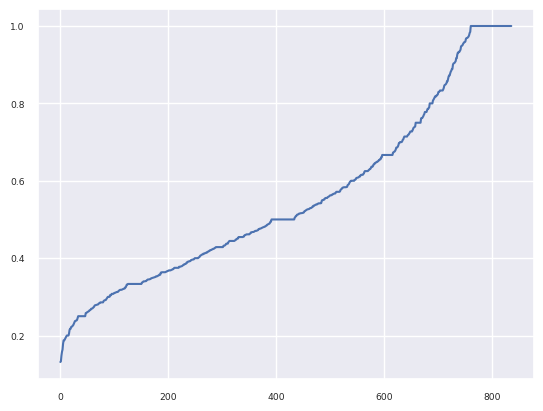

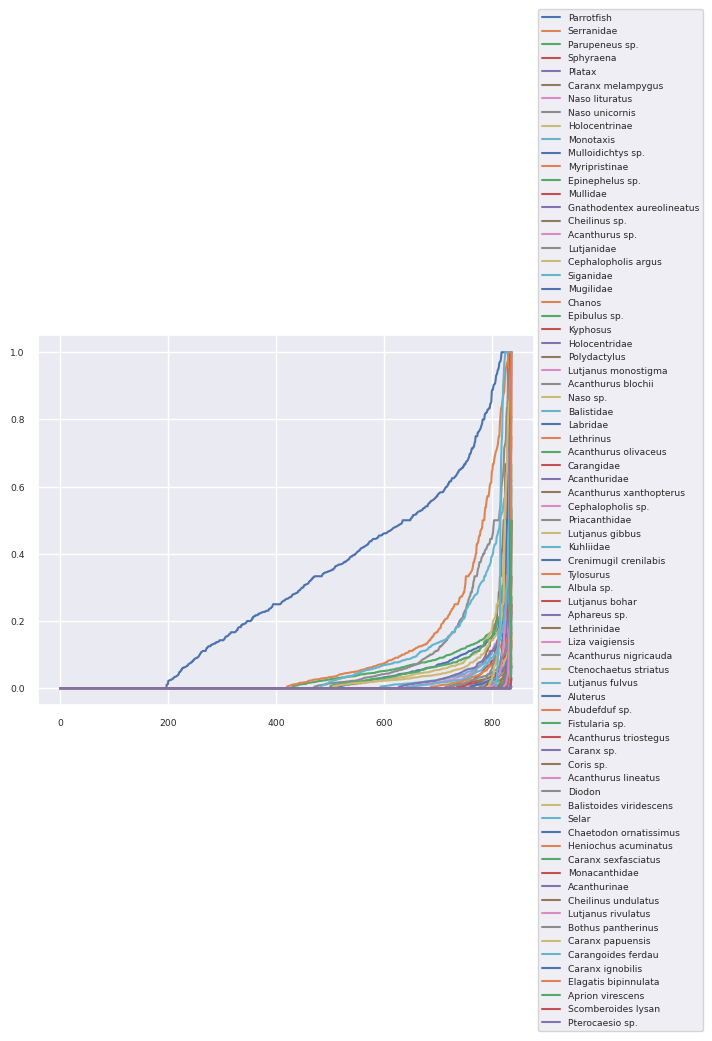

In [88]:
df_capture_freq['Valeur_Max'] = df_capture_freq[liste_especes].max(axis=1)
# print(df_capture_freq)
valeur_max = df_capture_freq['Valeur_Max']
valeur_max = valeur_max.sort_values()
# print(len(valeur_max))
plt.plot(np.arange(0, len(valeur_max)), valeur_max)
plt.show()

df_capture_grp = df_capture_total.groupby(['habitat', 'Gear'])
N = len(valeur_max)
for i in liste_especes :
  espece = df_capture_freq[i].sort_values()
  plt.plot(np.arange(0, N), espece, label = i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


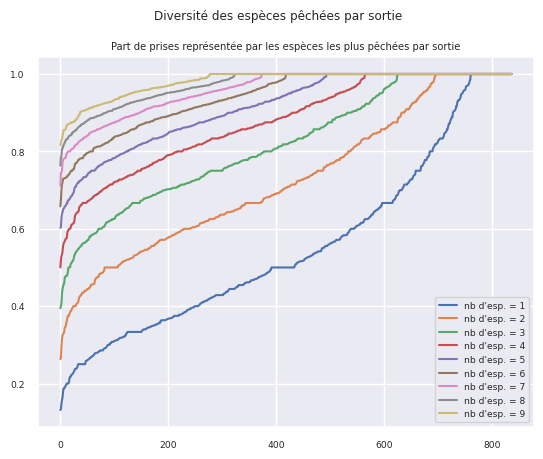

In [89]:
for i in range(1,10) :
  deux_max = df_capture_freq[liste_especes].apply(lambda row: row.nlargest(i).tolist(), axis=1)
  # deux_max = pd.DataFrame(deux_max, columns=["Somme 2 valeurs max"]).rename_axis('trk_index', axis=0)
  somme_deux = np.zeros(N)
  # print(deux_max)
  for s in range(N) :
    for j in range(i) :
      somme_deux[s] += deux_max[s][j]
  somme_deux = np.sort(somme_deux)
  plt.plot(np.arange(0,N), somme_deux, label="nb d'esp. = "+str(i))
plt.legend()
plt.title("Part de prises représentée par les espèces les plus pêchées par sortie")
plt.suptitle("Diversité des espèces pêchées par sortie")
plt.show()


### suivant la technique

<ipython-input-90-14bef4c5f4a6>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  capture_par_sortie_tech = df_capture_techn.sum(axis=1).sort_values()


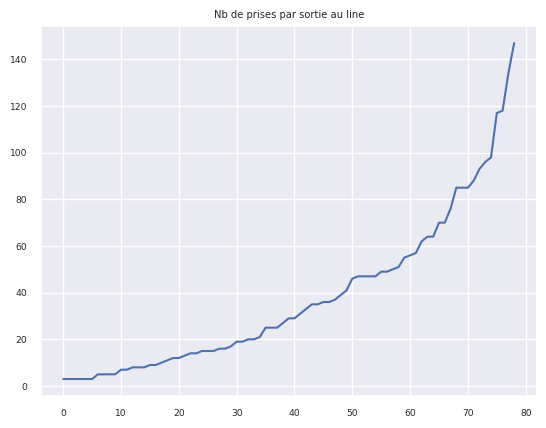

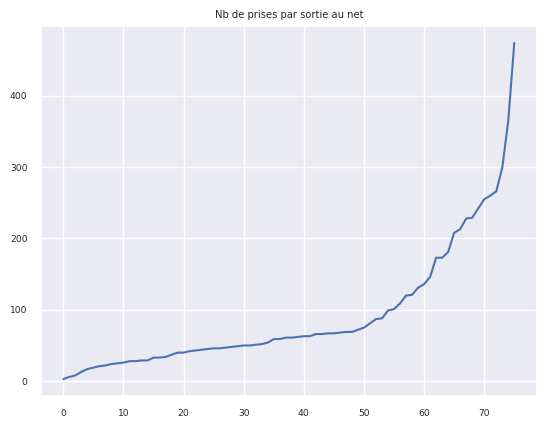

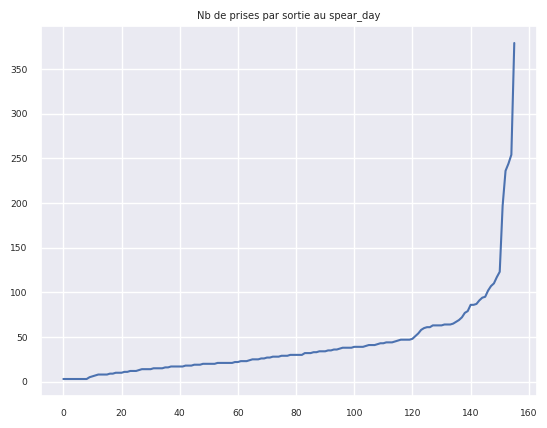

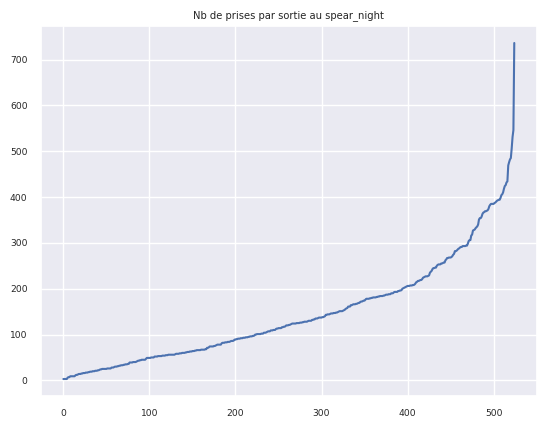

In [90]:
for technique in liste_techniques :
  df_capture_techn = df_capture_total[df_capture_total["Gear"] == technique]
  capture_par_sortie_tech = df_capture_techn.sum(axis=1).sort_values()
  plt.plot(np.arange(0, len(capture_par_sortie_tech)), capture_par_sortie_tech)
  plt.title("Nb de prises par sortie au "+technique)
  plt.show()

  ## Suggestion : ne garder que les sorties avec telle technique, dans tel habitat, ou telle nb de poissons pêchés, etc.

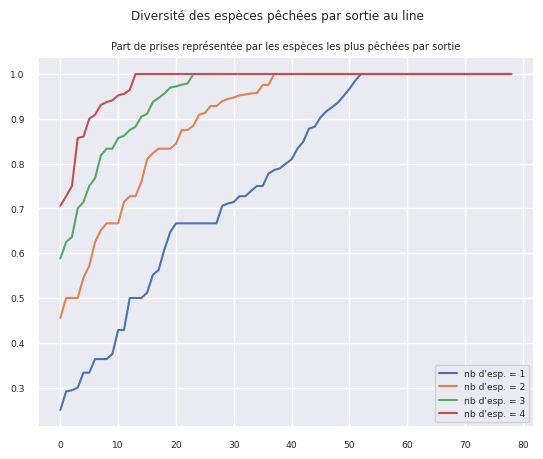

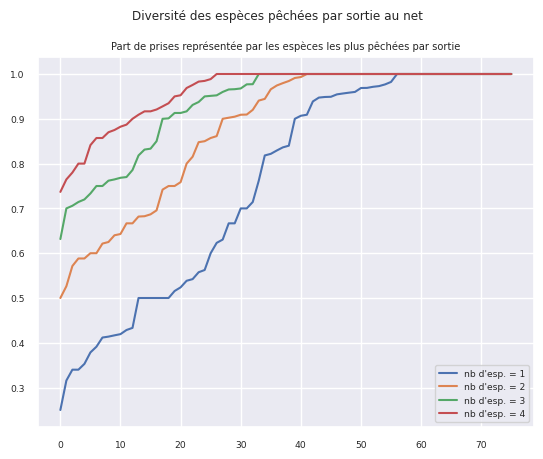

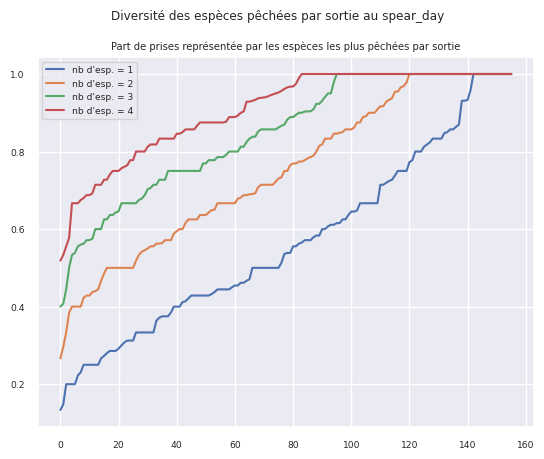

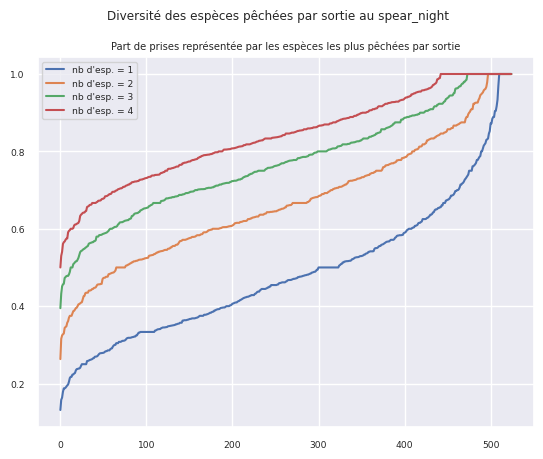

In [91]:
for technique in liste_techniques :
  sorties_tech = df_capture_total[df_capture_total["Gear"] == technique].index
  df_capture_freq_techn = df_capture_freq[df_capture_freq.index.isin(sorties_tech)]
  df_capture_freq_techn = df_capture_freq_techn.reset_index(drop=True)

  N = len(df_capture_freq_techn.index)
  for i in range(1,5) :
    deux_max = df_capture_freq_techn[liste_especes].apply(lambda row: row.nlargest(i).tolist(), axis=1)
    # deux_max = pd.DataFrame(deux_max, columns=["Somme 2 valeurs max"]).rename_axis('trk_index', axis=0)
    somme_deux = np.zeros(N)
    # print(deux_max)
    for s in range(N) :
      for j in range(i) :
        # print("s,j = "+str(s) + ", " + str(j))
        somme_deux[s] += deux_max[s][j]
    somme_deux = np.sort(somme_deux)
    plt.plot(np.arange(0,N), somme_deux, label="nb d'esp. = "+str(i))
  plt.legend()
  plt.title("Part de prises représentée par les espèces les plus pêchées par sortie")
  plt.suptitle("Diversité des espèces pêchées par sortie au "+technique)
  plt.show()

  ## Suggestion : ne garder que les sorties avec telle technique, dans tel habitat, ou telle nb de poissons pêchés, etc.

### suivant l'habitat

In [92]:
print(liste_habitats["Représentant"])
for habitat in liste_habitats["Représentant"] :
  print(habitat)

0    BackReef
1    Fringing
2     LagDeep
3    ForeReef
4        Pass
5         out
Name: Représentant, dtype: object
BackReef
Fringing
LagDeep
ForeReef
Pass
out


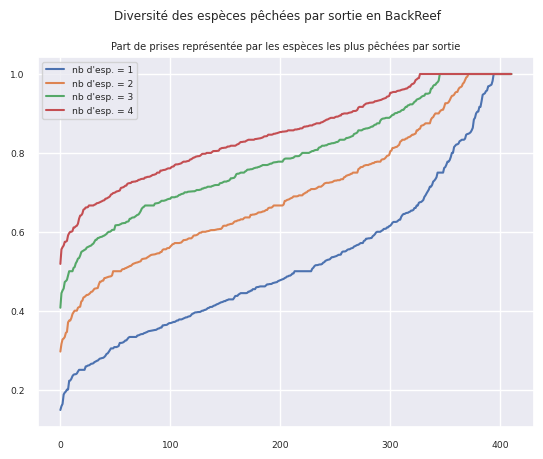

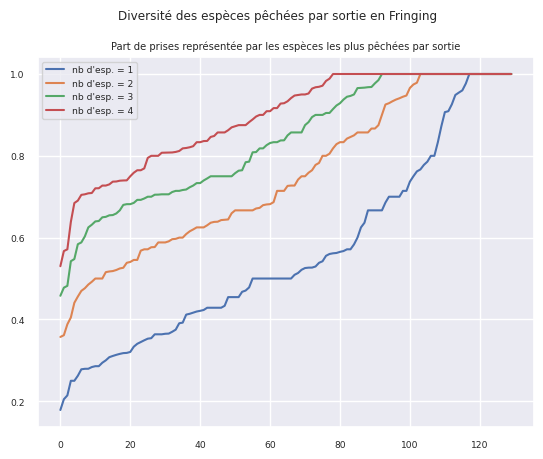

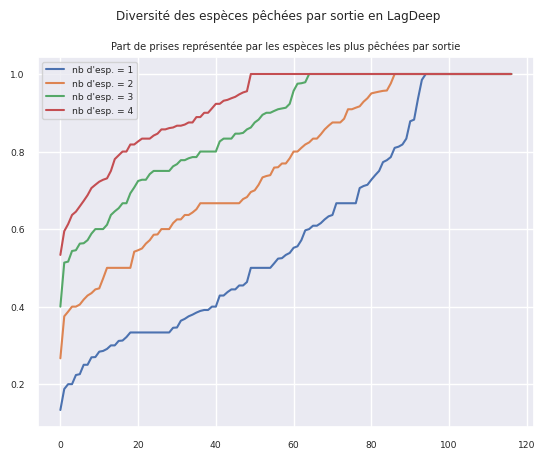

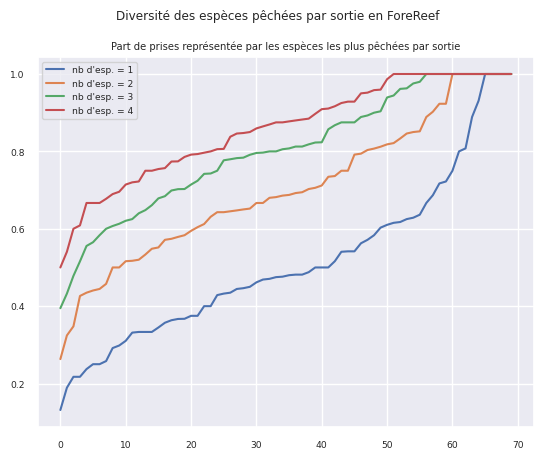

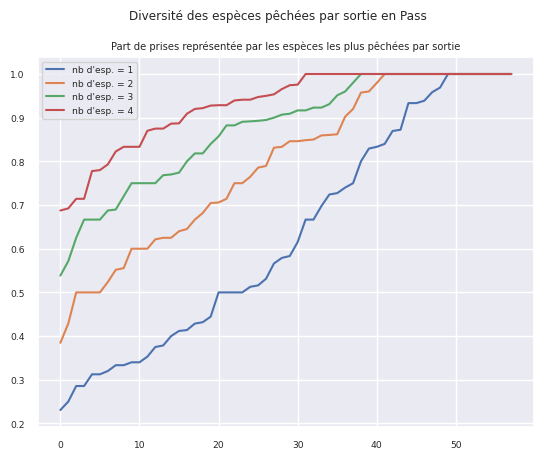

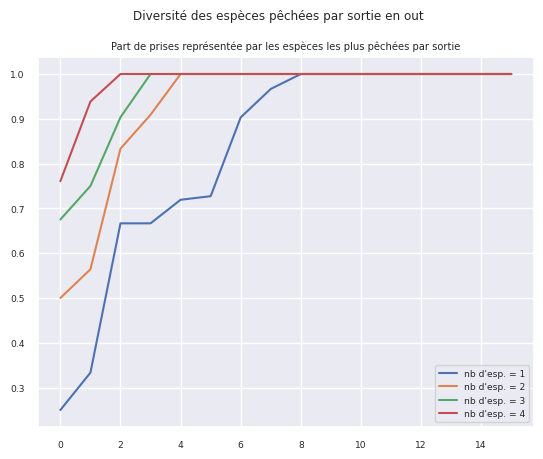

In [93]:
for habitat in liste_habitats["Représentant"] :
  sorties_hab = df_capture_total[df_capture_total["habitat"] == habitat].index
  df_capture_freq_hab = df_capture_freq[df_capture_freq.index.isin(sorties_hab)]
  df_capture_freq_hab = df_capture_freq_hab.reset_index(drop=True)

  N = len(df_capture_freq_hab.index)
  for i in range(1,5) :
    deux_max = df_capture_freq_hab[liste_especes].apply(lambda row: row.nlargest(i).tolist(), axis=1)
    # deux_max = pd.DataFrame(deux_max, columns=["Somme 2 valeurs max"]).rename_axis('trk_index', axis=0)
    somme_deux = np.zeros(N)
    # print(deux_max)
    for s in range(N) :
      for j in range(i) :
        # print("s,j = "+str(s) + ", " + str(j))
        somme_deux[s] += deux_max[s][j]
    somme_deux = np.sort(somme_deux)
    plt.plot(np.arange(0,N), somme_deux, label="nb d'esp. = "+str(i))
  plt.legend()
  plt.title("Part de prises représentée par les espèces les plus pêchées par sortie")
  plt.suptitle("Diversité des espèces pêchées par sortie en "+habitat)
  plt.show()

  ## Suggestion : ne garder que les sorties avec telle technique, dans tel habitat, ou telle nb de poissons pêchés, etc.

#Clusterings (KMeans, GMM, DBSCAN)

## Clustering selon la technique et l'habitat

In [94]:
# Création de ce df_capture_total déjà fait au-dessus
# df_capture_total = pd.merge(df_capture_technique, df_capture_habitat)

# df_capture_grp = df_capture_total.groupby(['habitat', 'Gear'])
somme_par_espece = df_capture_grp.sum()

#On regarde que les pêches ayant pris un nombre minimal de poisson pour que le comptage puisse etre utilisable.
nb_prises_min = 50
colonnes_relevent = somme_par_espece.loc[:,somme_par_espece.sum() > nb_prises_min]

#On regarde le pourcentage de prise par environnement
pourcent_par_espece_relevent = colonnes_relevent/colonnes_relevent.sum()


<ipython-input-94-917849ac9f2b>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  somme_par_espece = df_capture_grp.sum()


In [95]:
print(somme_par_espece)

                      nb_captures  nb_especes  Parrotfish  Serranidae  \
habitat  Gear                                                           
BackReef line               212.0          35         0.0         0.0   
         net               1564.0          71      1078.0         0.0   
         spear_day         1492.0         365       266.0         0.0   
         spear_night      25396.0        3224     10640.0         9.0   
ForeReef line                47.0          10         0.0         7.0   
         spear_day          169.0          57        71.0         3.0   
         spear_night       2511.0         447       562.0         2.0   
Fringing line               318.0          52         0.0         0.0   
         net                964.0         143       162.0         0.0   
         spear_day          272.0          49        45.0         0.0   
         spear_night       3700.0         601      1170.0         6.0   
LagDeep  line               592.0          99      